# ***Постановка задачи***

## Задача

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

Наименование файлов с данными

* course_project_train.csv - обучающий датасет
* course_project_test.csv - тестовый датасет

***Целевая переменная***

**Credit Default** - факт невыполнения кредитных обязательств

**Метрика качества**

*F1-score* (sklearn.metrics.f1_score)

**Требования к решению**

* Целевая метрика

**F1 > 0.5**

Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

**Решение должно содержать:**

* Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
* Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv

**Рекомендации для файла с кодом (ipynb):**

* Файл должен содержать заголовки и комментарии (markdown)
* Повторяющиеся операции лучше оформлять в виде функций
* Не делать вывод большого количества строк таблиц (5-10 достаточно)
* По возможности добавлять графики, описывающие данные (около 3-5)
* Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
* Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
* Весь проект должен быть в одном скрипте (файл ipynb).
* Допускается применение библиотек Python и моделей машинного обучения, которые были в данном курсе.

### Решение

**Установка пакетов и библиотек**

In [2072]:
from sklearn import metrics

import catboost as catb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as ex
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC as svc
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import os
# from google.colab import files
from catboost.utils import get_roc_curve, select_threshold
# import xgboost as xgb, lightgbm as lgbm
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingClassifier

#настройка графиков
sns.set(
font_scale=2,
style     ='whitegrid',
rc        ={'figure.figsize':(20,7)})

In [2073]:
import missingno as  msno

**Чтение и первичный анализ данных**

**Описание датасета**

* Home Ownership - домовладение
* Annual Income - годовой доход
* Years in current job - количество лет на текущем месте работы
* Tax Liens - налоговые обременения
* Number of Open Accounts - количество открытых счетов
* Years of Credit History - количество лет кредитной истории
* Maximum Open Credit - наибольший открытый кредит
* Number of Credit Problems - количество проблем с кредитом
* Months since last delinquent - количество месяцев с последней просрочки платежа
* Bankruptcies - банкротства
* Purpose - цель кредита
* Term - срок кредита
* Current Loan Amount - текущая сумма кредита
* Current Credit Balance - текущий кредитный баланс
* Monthly Debt - ежемесячный долг
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [2074]:
PATH_TRAIN = "C:\ВОВИНО\GEEKBRAINS\Classification_lessons\course_project_train.csv"

In [2075]:
PATH_TEST = "C:\ВОВИНО\GEEKBRAINS\Classification_lessons\course_project_test.csv"

In [2076]:
course_project_train = pd.read_csv(PATH_TRAIN)

In [2077]:
course_project_test = pd.read_csv(PATH_TEST)

In [2078]:
course_project_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [2079]:
#приведём в нижнему регистру и уберем пробелы для возможности обращения к фичам через точку (так иногда привычнее))
course_project_train.rename(columns=lambda x: x.replace(' ', '_').lower(), inplace=True)
course_project_train.head()

,home_ownership,annual_income,years_in_current_job,tax_liens,number_of_open_accounts,years_of_credit_history,maximum_open_credit,number_of_credit_problems,months_since_last_delinquent,bankruptcies,purpose,term,current_loan_amount,current_credit_balance,monthly_debt,credit_score,credit_default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [2080]:
course_project_test.rename(columns=lambda x: x.replace(' ', '_').lower(), inplace=True)

Общая информация

In [2081]:
course_project_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   home_ownership                7500 non-null   object 
 1   annual_income                 5943 non-null   float64
 2   years_in_current_job          7129 non-null   object 
 3   tax_liens                     7500 non-null   float64
 4   number_of_open_accounts       7500 non-null   float64
 5   years_of_credit_history       7500 non-null   float64
 6   maximum_open_credit           7500 non-null   float64
 7   number_of_credit_problems     7500 non-null   float64
 8   months_since_last_delinquent  3419 non-null   float64
 9   bankruptcies                  7486 non-null   float64
 10  purpose                       7500 non-null   object 
 11  term                          7500 non-null   object 
 12  current_loan_amount           7500 non-null   float64
 13  cur

In [2082]:
df = course_project_train.copy()

In [2083]:
df_test = course_project_test.copy()

In [2084]:
df.head()

,home_ownership,annual_income,years_in_current_job,tax_liens,number_of_open_accounts,years_of_credit_history,maximum_open_credit,number_of_credit_problems,months_since_last_delinquent,bankruptcies,purpose,term,current_loan_amount,current_credit_balance,monthly_debt,credit_score,credit_default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [2085]:
TARGET_NAME = 'credit_default'

***Напишем несколько функций, которые нам понабодятся в будущем.***

In [2086]:
#строим countplot в разрезе нашей переменной
def get_countplot(x, df=df, hue=TARGET_NAME, xlabel = '', ylabel = '\nCount',rotation=0):
    ax = sns.countplot(x=x, hue=hue, data=df)
    ax.set_title(f"{x} by {TARGET_NAME}")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha='right');

In [2087]:
#строим histplot в разрезе нашей переменной
def get_histplot(x, df=df, hue=TARGET_NAME, xlabel='', ylabel = '\nCount', bins=30):
    ax = sns.histplot(x=x,hue=hue,data=df,bins=bins)
    ax.set_title(f"{x} by {TARGET_NAME}")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel);

In [2088]:
#оценка вероятности отнесения к таргету по переменной
def get_prob_target(x, df=df):
    return df.groupby(f'{x}',as_index=False)\
      .agg({TARGET_NAME:np.mean})

In [2089]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [2090]:
# функция отчетов
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [2091]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls    = []
    f1_scores  = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
    
    
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
#     plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [2092]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

##### Общий анализ

Пропущенные значения

In [2093]:
course_project_train.isna().sum()

home_ownership                     0
annual_income                   1557
years_in_current_job             371
tax_liens                          0
number_of_open_accounts            0
years_of_credit_history            0
maximum_open_credit                0
number_of_credit_problems          0
months_since_last_delinquent    4081
bankruptcies                      14
purpose                            0
term                               0
current_loan_amount                0
current_credit_balance             0
monthly_debt                       0
credit_score                    1557
credit_default                     0
dtype: int64

Видно, что предстоит обратботка пропущенных значений:

annual_income, years_in_current_job, months_since_last_delinquent, bankruptcies, credit_score

In [2094]:
df_test.isna().sum()

home_ownership                     0
annual_income                    513
years_in_current_job              86
tax_liens                          0
number_of_open_accounts            0
years_of_credit_history            0
maximum_open_credit                0
number_of_credit_problems          0
months_since_last_delinquent    1358
bankruptcies                       3
purpose                            0
term                               0
current_loan_amount                0
current_credit_balance             0
monthly_debt                       0
credit_score                     513
dtype: int64

У тестового датафрейма пропущеные в тех же признаках.

In [2095]:
course_project_train.describe().T

,count,mean,std,min,25%,50%,75%,max
annual_income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
tax_liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
number_of_open_accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
years_of_credit_history,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
maximum_open_credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
number_of_credit_problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
months_since_last_delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
current_loan_amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
current_credit_balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06


In [2096]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
annual_income,1987.0,1.366922e+06,9.171252e+05,106533.0,852311.50,1178475.0,1629734.5,14975610.0
tax_liens,2500.0,3.520000e-02,3.862909e-01,0.0,0.00,0.0,0.0,15.0
number_of_open_accounts,2500.0,1.118440e+01,4.852774e+00,1.0,8.00,10.0,14.0,48.0
years_of_credit_history,2500.0,1.832592e+01,7.254659e+00,3.9,13.40,17.0,22.1,53.4
maximum_open_credit,2500.0,7.105704e+05,1.511983e+06,0.0,278586.00,478676.0,802598.5,54484386.0
number_of_credit_problems,2500.0,1.620000e-01,5.598941e-01,0.0,0.00,0.0,0.0,15.0
months_since_last_delinquent,1142.0,3.418126e+01,2.202428e+01,0.0,16.00,30.0,50.0,82.0
bankruptcies,2497.0,1.069283e-01,3.571893e-01,0.0,0.00,0.0,0.0,5.0
current_loan_amount,2500.0,1.215572e+07,3.226097e+07,15422.0,187126.50,322366.0,522582.5,99999999.0
current_credit_balance,2500.0,2.963966e+05,3.783020e+05,0.0,110114.50,207385.0,366348.5,6030087.0


На первый взгляд тестовые данные похожи. В целом далее мы будем работать с train'ом, считая что он взят из той же генеральой совокупности, что и тестовые данные, и будем применять все преобразования с train на тест.

И обработка выбросов в переменных 'maximum_open_credit', 'current_loan_amount', 'credit_score'

**Проверим целевую переменную**

In [2097]:
course_project_train.credit_default.value_counts()

0    5387
1    2113
Name: credit_default, dtype: int64

In [2098]:
f'Верояность попадания в положительный класс = {2113/7500:.2f}'

'Верояность попадания в положительный класс = 0.28'

In [2099]:
(df[TARGET_NAME].mean() * 100).round(2)

28.17

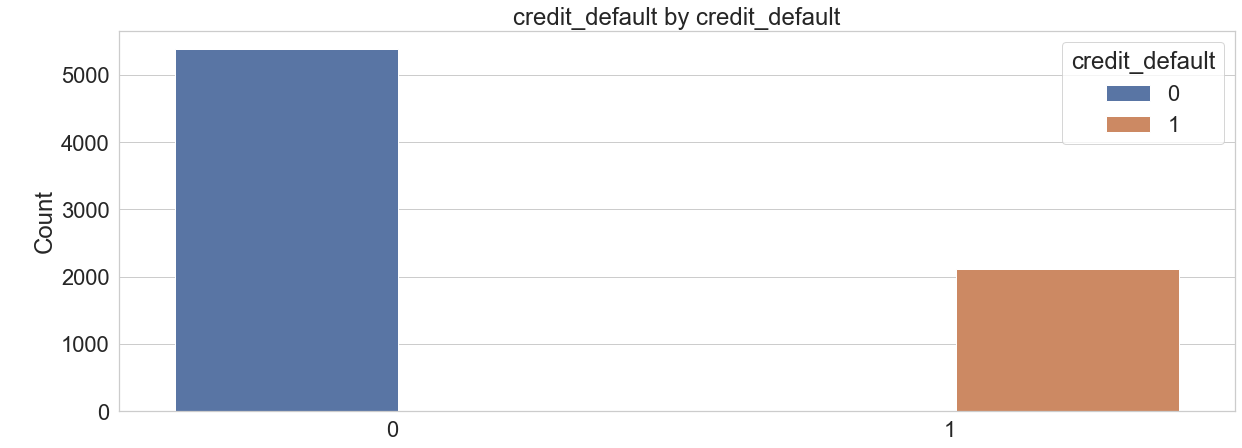

In [2100]:
get_countplot(x=TARGET_NAME)

Видим несбалансированность целевой переменной, что будем учитывать при обучение модели.

**Анализ каждой из переменной**

In [2101]:
#временно добавим id для разсчётов
df['id'] = np.arange(0, df.shape[0])

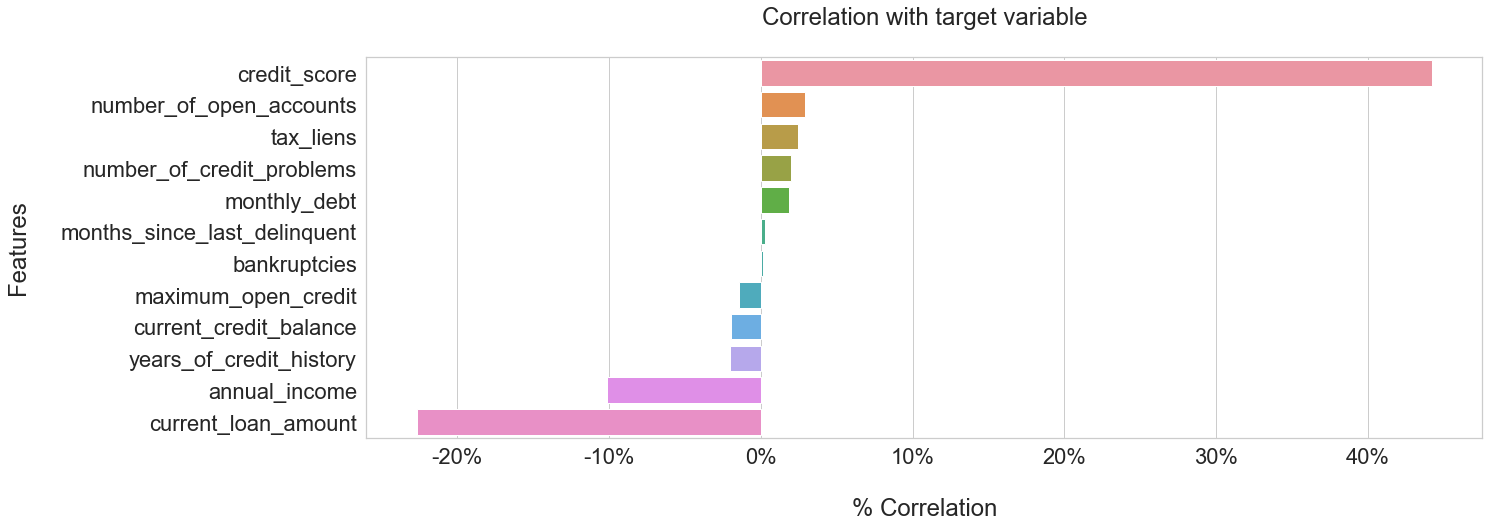

In [2102]:
corr_with_target = course_project_train.corr().iloc[:-1, -1].sort_values(ascending=False)

ax=sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

ax.set_title('Correlation with target variable\n')
ax.set_xlabel('\n% Correlation')
ax.set_xticklabels([f'{x:.0%}' for x in ax.get_xticks()])
ax.set_ylabel('Features\n');

In [2103]:
df.columns

Index(['home_ownership', 'annual_income', 'years_in_current_job', 'tax_liens',
       'number_of_open_accounts', 'years_of_credit_history',
       'maximum_open_credit', 'number_of_credit_problems',
       'months_since_last_delinquent', 'bankruptcies', 'purpose', 'term',
       'current_loan_amount', 'current_credit_balance', 'monthly_debt',
       'credit_score', 'credit_default', 'id'],
      dtype='object')

**Home Ownership**

In [2104]:
df.home_ownership.value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: home_ownership, dtype: int64

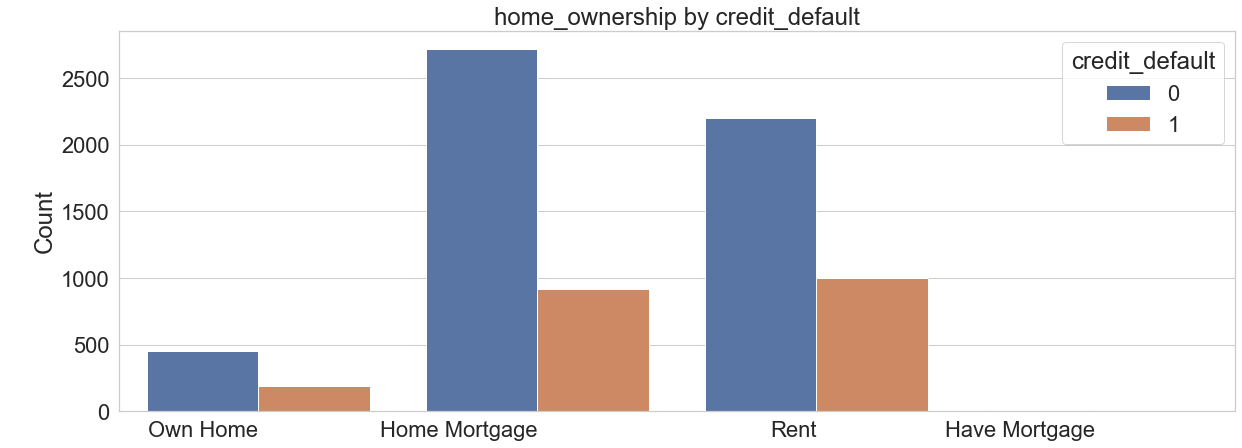

In [2105]:
get_countplot('home_ownership')

In [2106]:
get_prob_target('home_ownership')

,home_ownership,credit_default
0,Have Mortgage,0.166667
1,Home Mortgage,0.251856
2,Own Home,0.296754
3,Rent,0.313046


Видим, что распределение в категории home_mortage и rent имеют схожие доли в разрезе целевой переменной. Возможно, стоит их объединить в одну категорию.

**Гипотеза**

* Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
* Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* Критерий: Хи-квадрат Пирсона
* Уровень значимости  α : 0.05
* Критическая область: двухсторонняя

Для проверки данной гипотезы необходимо подать наблюдаемые частоты категорий Home Mortgage и Rent признака home_ownership в выбранный критерий, после чего оценить значение достигаемого уровня значимости p-value и сравнить с его с выбранным порогом альфа, если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.

In [2107]:
home_and_target_s = df.loc[df.home_ownership.isin(['Home Mortgage', 'Rent']), ['id','home_ownership', TARGET_NAME]].sample(2000)

In [2108]:
table = home_and_target_s.pivot_table(values='id', index='home_ownership', columns=TARGET_NAME, aggfunc='count')
table

credit_default,0,1
home_ownership,,
Home Mortgage,800,274
Rent,611,315


*Проверим нашу гипотезу используя критерий Хи-квадрат Пирсона*

In [2109]:
chi2, p, dof, expected = scipy.stats.chi2_contingency(table, correction=False)
p

3.170302034139192e-05

Р-value говорит о том, что мы можем уверенно отвергнуть нулевую гипотезу. Показатели по разному влияют на целевую.

Проверим на Home Mortgage & Own Home.

In [2110]:
home_and_target_s = df.loc[df.home_ownership.isin(['Home Mortgage', 'Own Home']), ['id','home_ownership', TARGET_NAME]].sample(2000)

In [2111]:
table = home_and_target_s.pivot_table(values='id', index='home_ownership', columns=TARGET_NAME, aggfunc='count')
table

credit_default,0,1
home_ownership,,
Home Mortgage,1273,432
Own Home,211,84


In [2112]:
chi2, p, dof, expected = scipy.stats.chi2_contingency(table, correction=False)
p

0.25548736063139244

In [2113]:
# Отвергаем нулевую гипотезу, объединяем признаки.
df.loc[df.home_ownership.isin(['Home Mortgage','Own Home']),'home_ownership'] = 'Home'

In [2114]:
df_test.loc[df_test.home_ownership.isin(['Home Mortgage','Own Home']),'home_ownership'] = 'Home'

In [2115]:
get_prob_target('home_ownership')

,home_ownership,credit_default
0,Have Mortgage,0.166667
1,Home,0.258637
2,Rent,0.313046


**Annual Income**

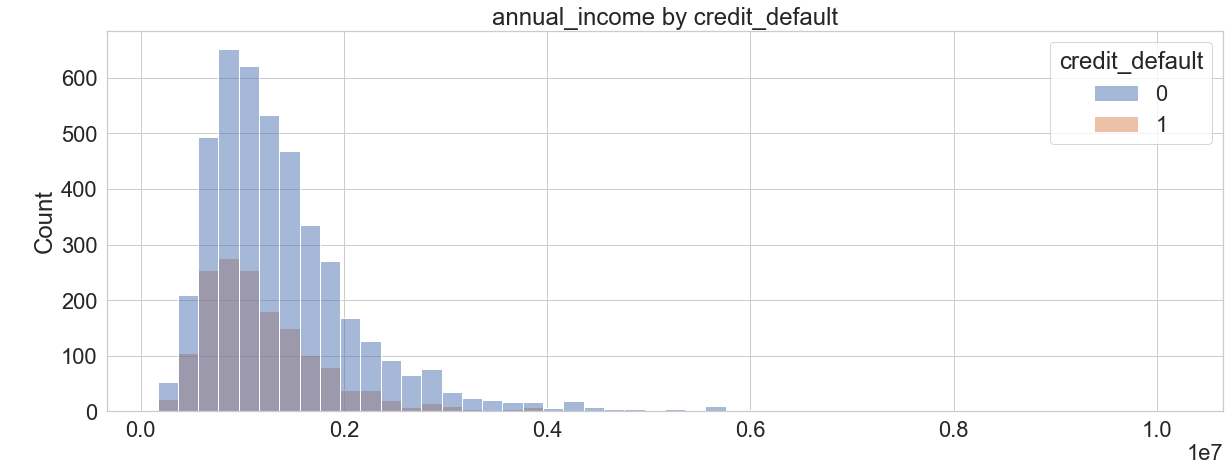

In [2116]:
get_histplot('annual_income',bins=50)

In [2117]:
df.annual_income.isna().sum()

1557

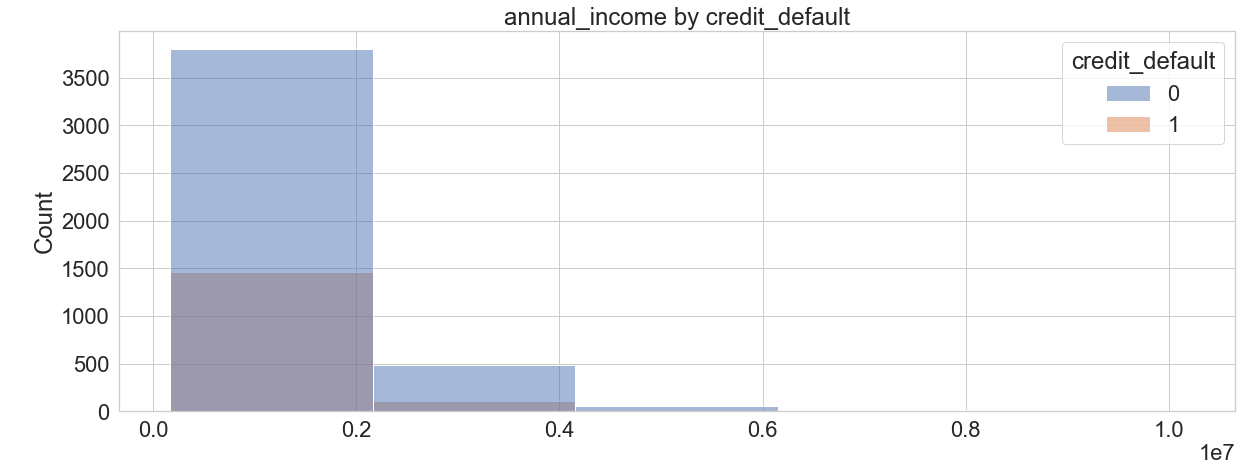

In [2118]:
get_histplot(df=df[~df.annual_income.isna()],x='annual_income',bins=5)

С учётом неравномерного распределения показателя, имеет смысл заполнить пропущенные значение медианой или сгруппированной величиной.
Проверим с каким признаком коррелирует больше всего.

In [2119]:
df.corr()['annual_income'].sort_values(ascending=False)

annual_income                   1.000000
monthly_debt                    0.584819
current_credit_balance          0.386481
number_of_open_accounts         0.188524
years_of_credit_history         0.186531
tax_liens                       0.066245
maximum_open_credit             0.062218
current_loan_amount             0.032082
id                              0.011426
number_of_credit_problems      -0.015407
credit_score                   -0.037832
bankruptcies                   -0.066877
credit_default                 -0.101375
months_since_last_delinquent   -0.101787
Name: annual_income, dtype: float64

<AxesSubplot:xlabel='years_in_current_job', ylabel='annual_income'>

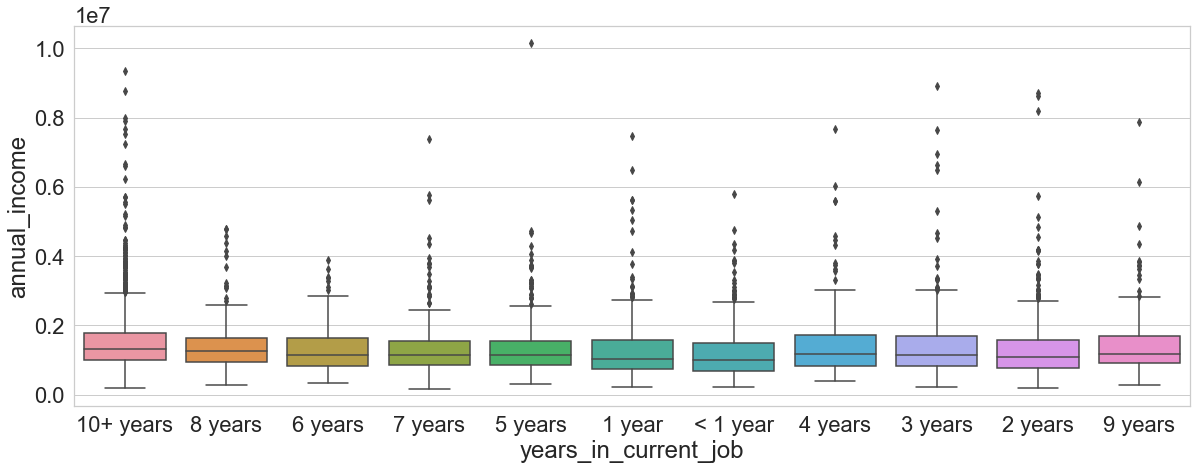

In [2120]:
sns.boxplot(data=df, x='years_in_current_job',y='annual_income')

<AxesSubplot:xlabel='term', ylabel='annual_income'>

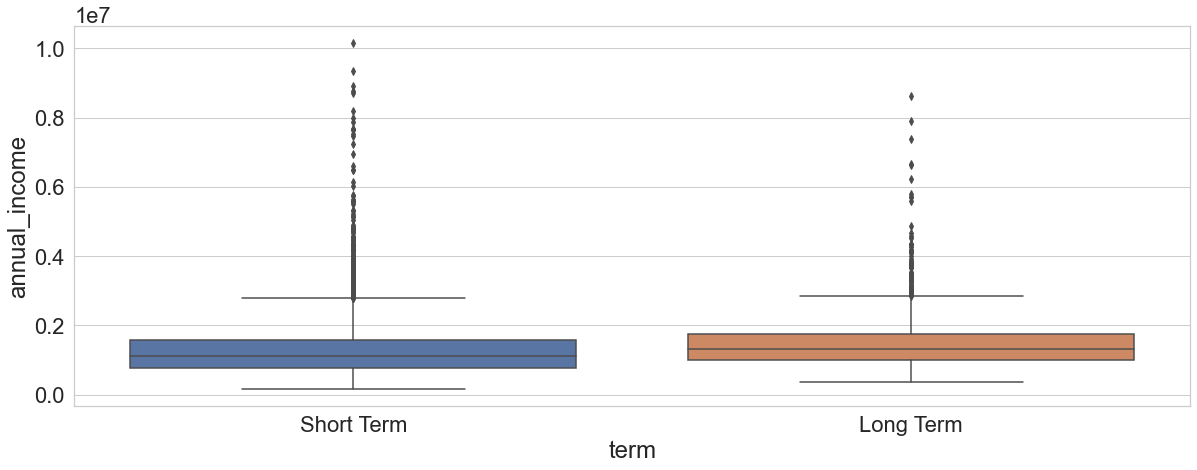

In [2121]:
sns.boxplot(data=df, x='term', y='annual_income')

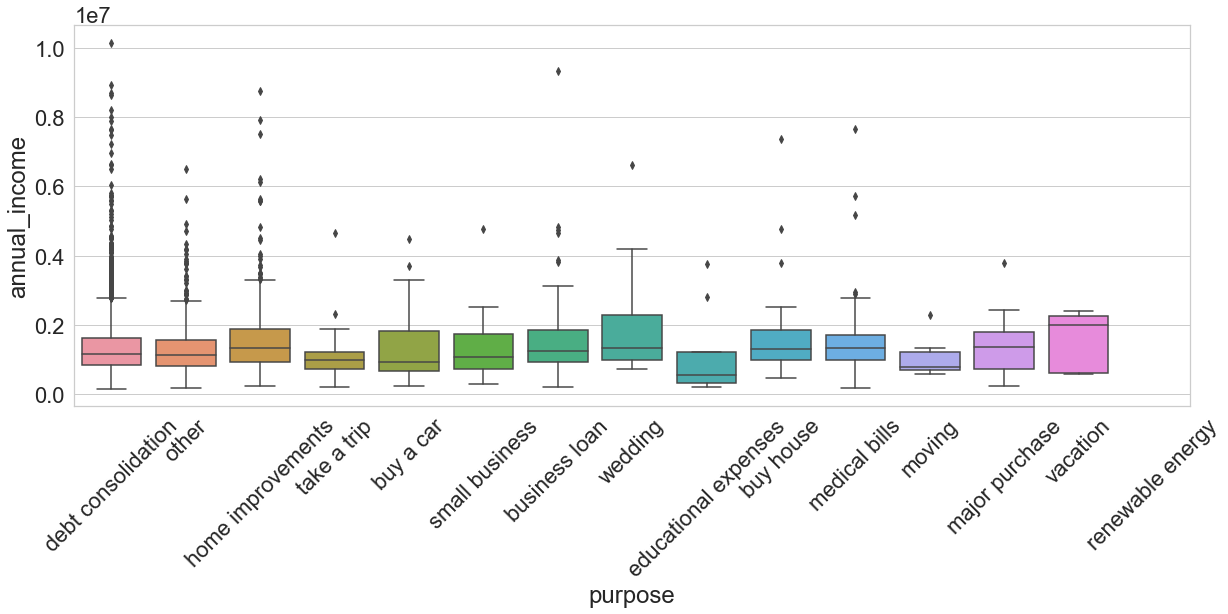

In [2122]:
ax=sns.boxplot(data=df, x='purpose', y='annual_income')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45);

Видно, что основные различия по всем категориальным группам за счёт выбросов. И в итоге заполнять пропуски можно как константой, так и медианой.

Вариант с константой

In [2123]:
# df.annual_income.fillna(-9999,inplace=True)

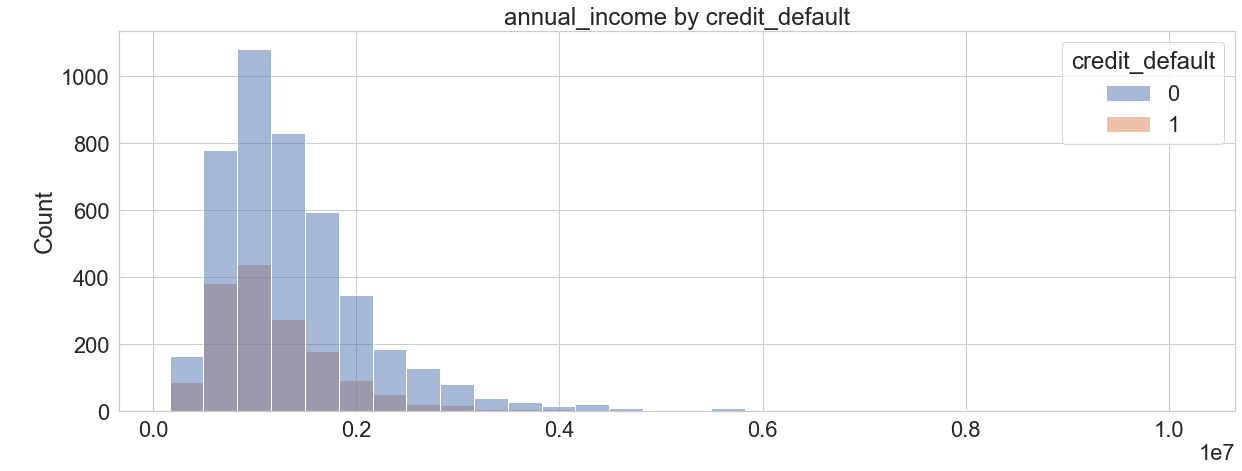

In [2124]:
get_histplot('annual_income')

In [2125]:
# df.query('annual_income < 0')\
#   .agg({TARGET_NAME:'mean'})

In [2126]:
# df.query('annual_income > 0')\
#   .agg({TARGET_NAME:'mean'})

В пропущенных значениях вероятность по целевой переменной выше, чем в среднем. Оставим пропущенные константой.

Посмотрим на monthly_debt

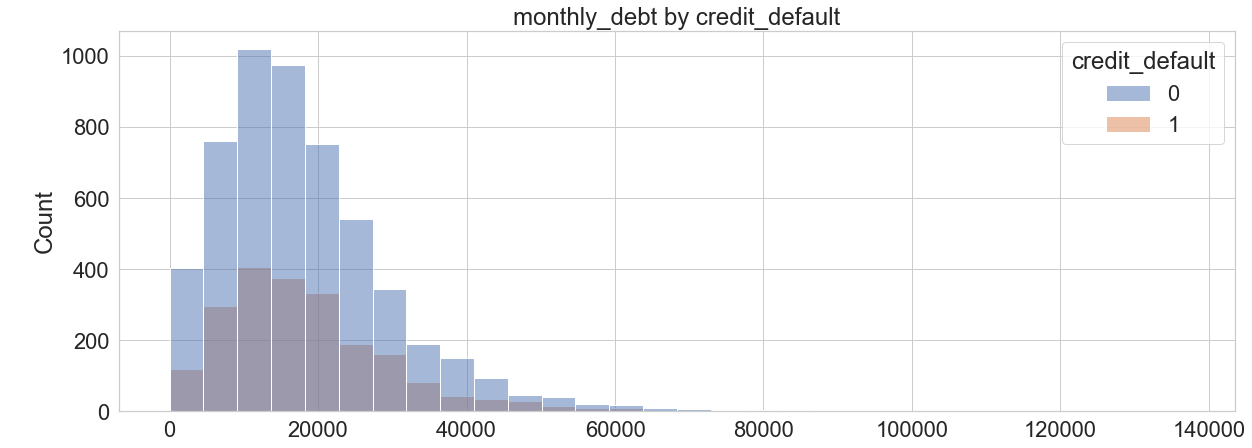

In [2127]:
get_histplot('monthly_debt')

In [2128]:
df.monthly_debt.describe()

count      7500.000000
mean      18314.454133
std       11926.764673
min           0.000000
25%       10067.500000
50%       16076.500000
75%       23818.000000
max      136679.000000
Name: monthly_debt, dtype: float64

Проверим в разрезе целевой переменной

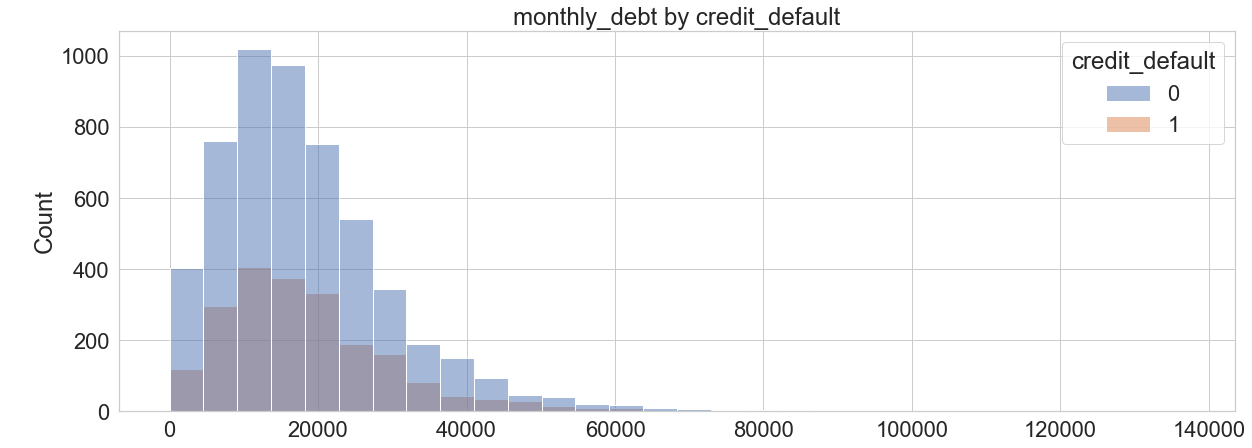

In [2129]:
get_histplot('monthly_debt',bins=30)

Визуально значимой разницы не видно. Проверим

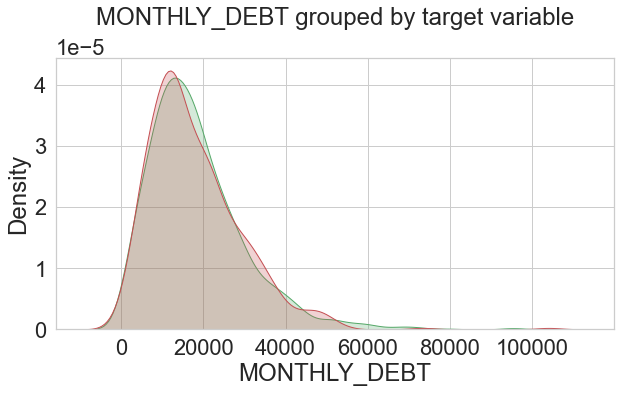

In [2130]:
monthly_debt_with_target_s = df[['monthly_debt', TARGET_NAME]].sample(2000)
monthky_debt_s = monthly_debt_with_target_s['monthly_debt']
target_0 = monthky_debt_s[monthly_debt_with_target_s[TARGET_NAME] == 0]
target_1 = monthky_debt_s[monthly_debt_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(target_0, shade=True, label='No default', color='g')
sns.kdeplot(target_1, shade=True, label='Default', color='r')

plt.xlabel('MONTHLY_DEBT')
plt.title('MONTHLY_DEBT grouped by target variable\n')
plt.show()

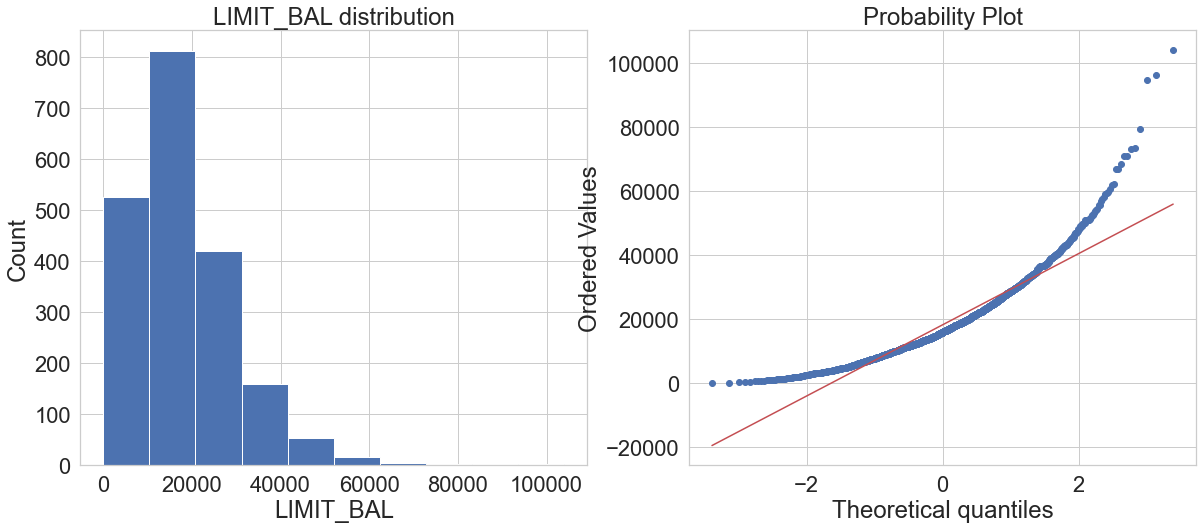

In [2131]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('LIMIT_BAL')
ax1.set_ylabel('Count')
ax1.set_title('LIMIT_BAL distribution')
monthky_debt_s.hist()

plt.subplot(122)
scipy.stats.probplot(monthky_debt_s, dist='norm', plot=plt)

plt.show()

In [2132]:
scipy.stats.shapiro(monthky_debt_s)

ShapiroResult(statistic=0.8997159004211426, pvalue=2.6778036818220183e-34)

В следствие ненормальности распределения, использует критерий Минна-Уитни

In [2133]:
scipy.stats.mannwhitneyu(target_0, target_1)

MannwhitneyuResult(statistic=392365.0, pvalue=0.3310822472260928)

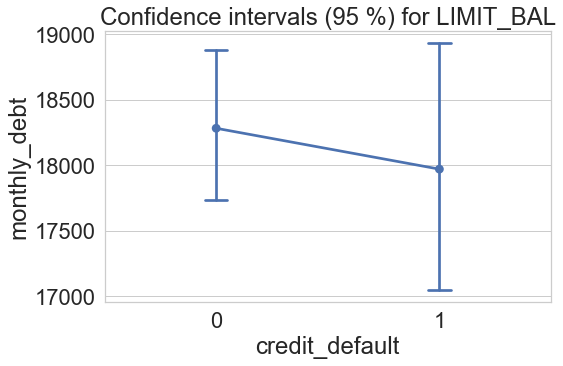

In [2134]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='monthly_debt', data=monthly_debt_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for LIMIT_BAL')
plt.show()

Видим, что нет оснований отвергать нулевую гипотезу о равенстве средних.

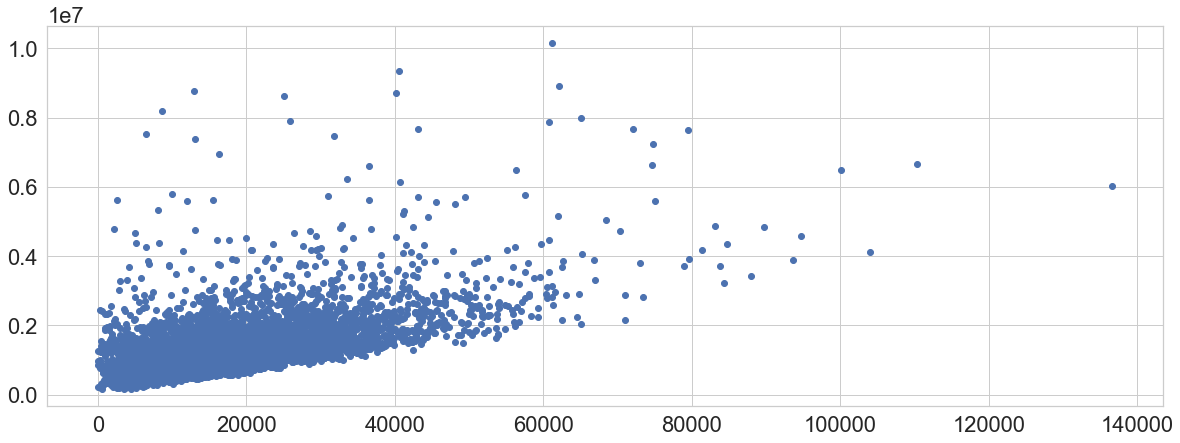

In [2135]:
plt.scatter(x='monthly_debt', y='annual_income', data=df)

In [2136]:
gbr = GradientBoostingRegressor()

In [2137]:
trainX=np.array(df.monthly_debt.loc[~df.annual_income.isna()]).reshape(-1,1)

In [2138]:
df.monthly_debt.loc[~df.annual_income.isna()]

0        7914.0
1       18373.0
2       13651.0
3       11338.0
4        7180.0
         ...   
7491    61150.0
7493    27562.0
7495     1900.0
7496    12783.0
7497    12479.0
Name: monthly_debt, Length: 5943, dtype: float64

In [2139]:
trainY=df.annual_income.loc[~df.annual_income.isna()]

In [2140]:
testX=np.array(df.monthly_debt.loc[df.annual_income.isna()]).reshape(-1,1)
testX_test = np.array(df_test.monthly_debt.loc[df_test.annual_income.isna()]).reshape(-1,1)

In [2141]:
df.monthly_debt.loc[df.annual_income.isna()]

5       18692.0
8          17.0
9       17613.0
10      14592.0
16      18844.0
         ...   
7482    23506.0
7492    20966.0
7494     5070.0
7498    37118.0
7499     9061.0
Name: monthly_debt, Length: 1557, dtype: float64

In [2142]:
gbr.fit(trainX, trainY)

GradientBoostingRegressor()

In [2143]:
pred_annual_income = gbr.predict(testX)
pred_annual_income_test = gbr.predict(testX_test)

In [2144]:
temp_df =  pd.DataFrame(df.monthly_debt.loc[df.annual_income.isna()])
temp_df['pred'] = pred_annual_income


In [2145]:
temp_df_test =  pd.DataFrame(df_test.monthly_debt.loc[df_test.annual_income.isna()])
temp_df_test['pred'] = pred_annual_income_test


In [2146]:
df.annual_income.fillna(temp_df.pred, inplace=True)

In [2147]:
df_test.annual_income.fillna(temp_df_test.pred, inplace=True)

In [2148]:
df.annual_income.isna().sum()

0

In [2149]:
df_test.annual_income.isna().sum()

0

Теперь рассмотрим в разрезе целевой переменной

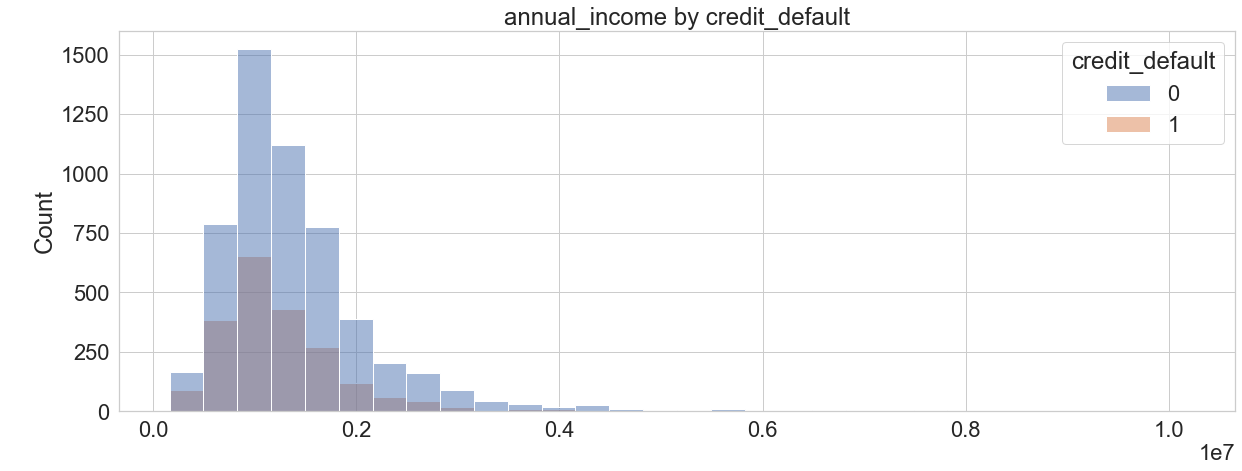

In [2150]:
get_histplot('annual_income')

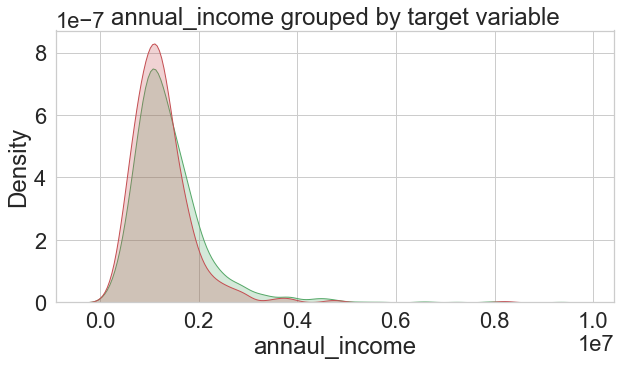

In [2151]:
annual_with_target_s = df[['annual_income', TARGET_NAME]].sample(2000)
annual_s = annual_with_target_s['annual_income']
annual_target_0 = annual_s[annual_with_target_s[TARGET_NAME] == 0]
annual_target_1 = annual_s[annual_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(annual_target_0, shade=True, label='No default', color='g')
sns.kdeplot(annual_target_1, shade=True, label='Default', color='r')

plt.xlabel('annaul_income')
plt.title('annual_income grouped by target variable')
plt.show()

In [2152]:
scipy.stats.shapiro(annual_s)

ShapiroResult(statistic=0.7727340459823608, pvalue=0.0)

In [2153]:
scipy.stats.mannwhitneyu(annual_target_0, annual_target_1)

MannwhitneyuResult(statistic=342278.0, pvalue=4.230395164348615e-06)

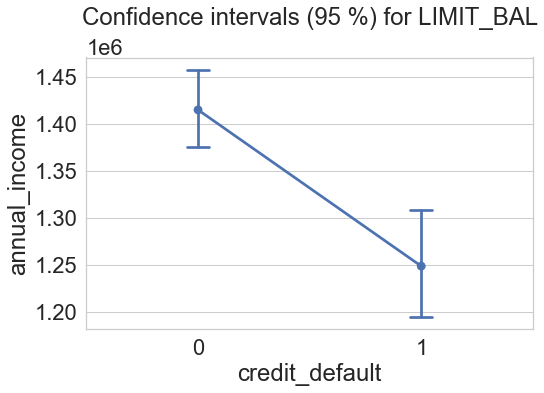

In [2154]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='annual_income', data=annual_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for LIMIT_BAL\n')
plt.show()

Видим, что средние значения по целевой переменной значимо отличаются. и это признак может быть полезен для определения целевой переменной.


**Произведем log-трансформацию признака**

In [2155]:
df['annual_income_log'] = df.annual_income.apply(np.log)

In [2156]:
df_test['annual_income_log'] = df_test.annual_income.apply(np.log)

**years_in_current_job**

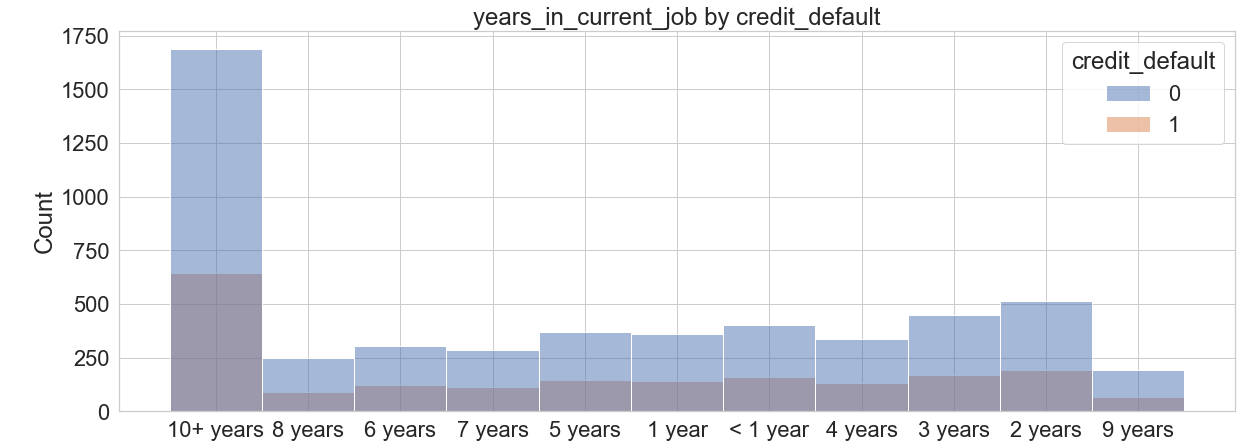

In [2157]:
get_histplot('years_in_current_job')

Оценим пропуски в разрезе таргета.

In [2158]:
df.loc[df.years_in_current_job.isna(),['years_in_current_job',TARGET_NAME]].agg({TARGET_NAME:'mean'})

credit_default    0.369272
dtype: float64

Вероятность попадания в таргет выше среднего. Оставим константой.

In [2159]:
# df.years_in_current_job.fillna('na', inplace=True)

<!-- Заменим пропущенные на наиболее часто встречаемые. -->

Произведем замену на моду.

In [2160]:
df.years_in_current_job.mode()[0]

'10+ years'

In [2161]:
df.years_in_current_job.fillna(df.years_in_current_job.mode()[0], inplace=True)

In [2162]:
df_test.years_in_current_job.fillna(df.years_in_current_job.mode()[0], inplace=True)

<AxesSubplot:xlabel='years_in_current_job', ylabel='Count'>

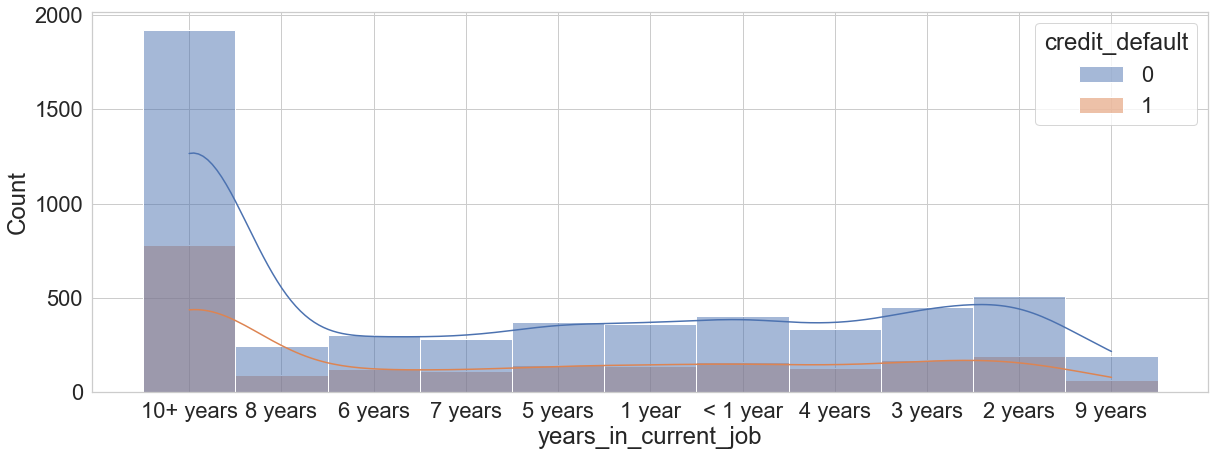

In [2163]:
sns.histplot(x='years_in_current_job', hue=TARGET_NAME,kde=True, alpha=0.5, data=df)

<AxesSubplot:xlabel='years_in_current_job', ylabel='count'>

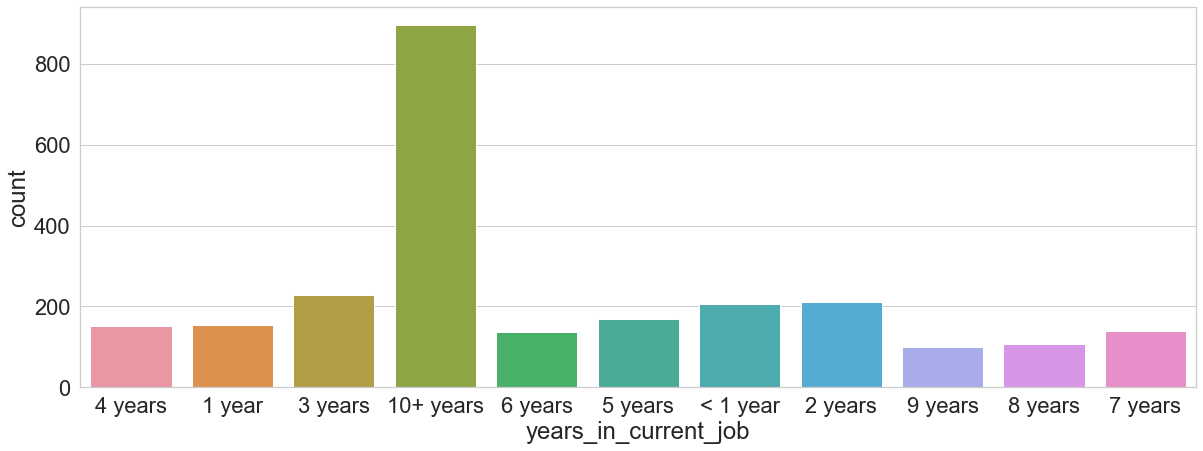

In [2164]:
sns.countplot(data=df_test,x='years_in_current_job')

***years_of_credit_history***

In [2165]:
df.years_of_credit_history.value_counts()

15.0    104
16.0     99
16.5     91
17.0     86
17.5     83
       ... 
43.5      1
50.0      1
40.1      1
51.5      1
41.6      1
Name: years_of_credit_history, Length: 408, dtype: int64

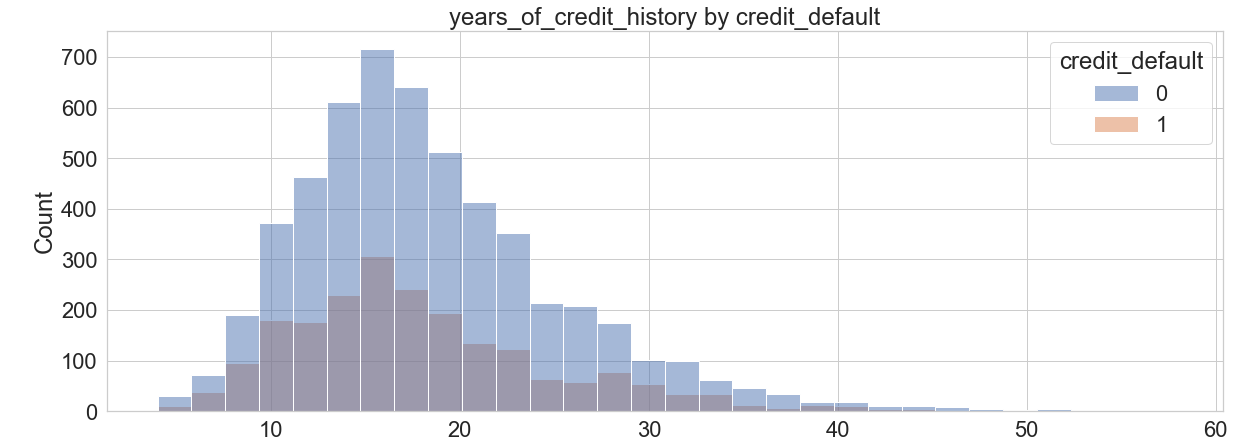

In [2166]:
get_histplot('years_of_credit_history', bins=30)

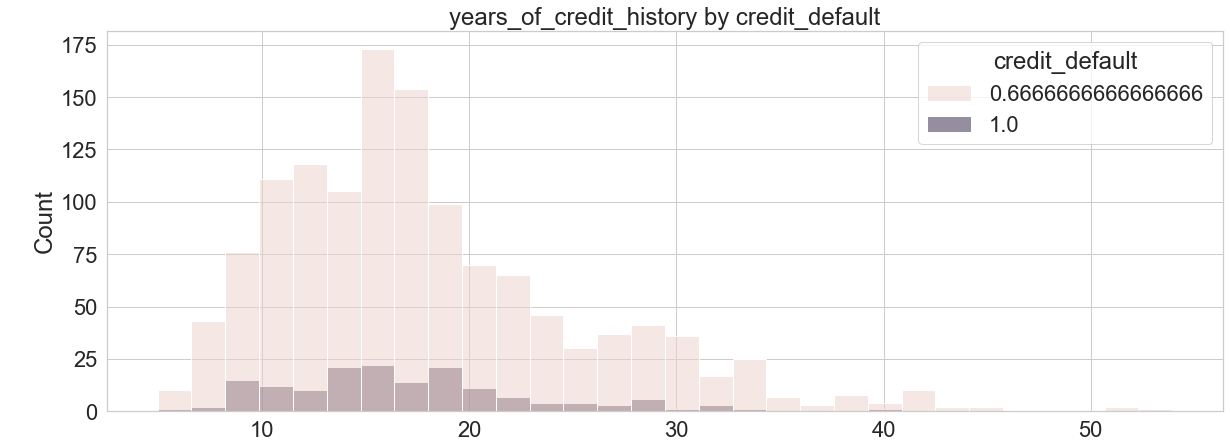

In [2167]:
#построим график распределения высоковероятного таргета( выше 0,5) в связи длительности кредитной истории
get_histplot(df=df[['years_of_credit_history',TARGET_NAME]]\
  .sort_values(by='years_of_credit_history')\
  .rolling(3,min_periods=1)\
  .mean()\
  .query('credit_default > 0.4'),x='years_of_credit_history')

Видно условные "окошки" от 0 до 10, от 10 до 30, и больше 30.
Попробуем разбить на эти категории.
Хотя, есть риск переобучения, ведь новые данные могут не совсем совпадать.

In [2168]:
bins=[0,
     10,     
     30,
     df.years_of_credit_history.max()]

In [2169]:
labels=['less 10',
       '10 - 30',
       'more 30']

In [2170]:
df['years_credit_history_rank'] = pd.cut(df.years_of_credit_history,bins=bins,labels=labels)

In [2171]:
df_test['years_credit_history_rank'] =pd.cut(df_test.years_of_credit_history,bins=bins,labels=labels)

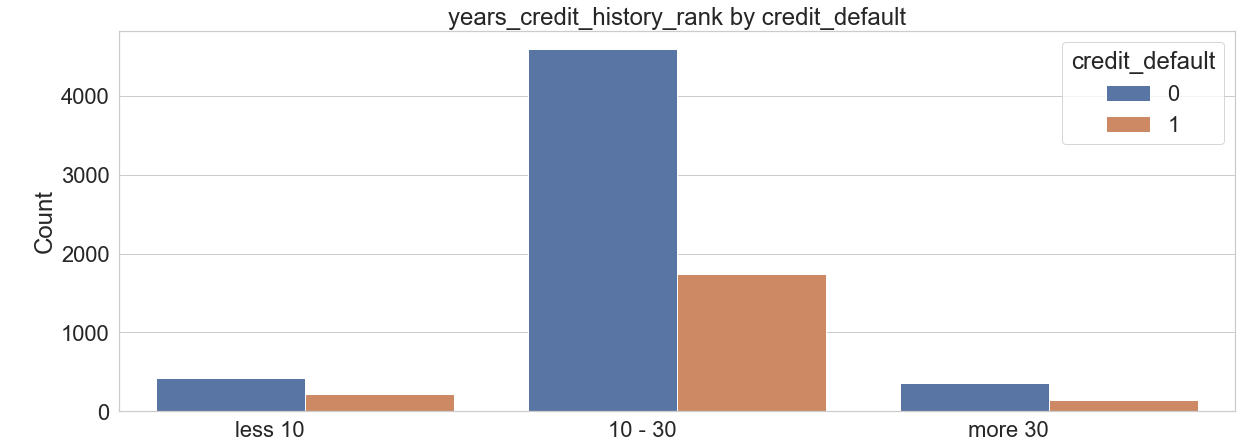

In [2172]:
get_countplot('years_credit_history_rank')

In [2173]:
get_prob_target('years_credit_history_rank')

,years_credit_history_rank,credit_default
0,less 10,0.341538
1,10 - 30,0.274807
2,more 30,0.291585


**tax_liens**                     

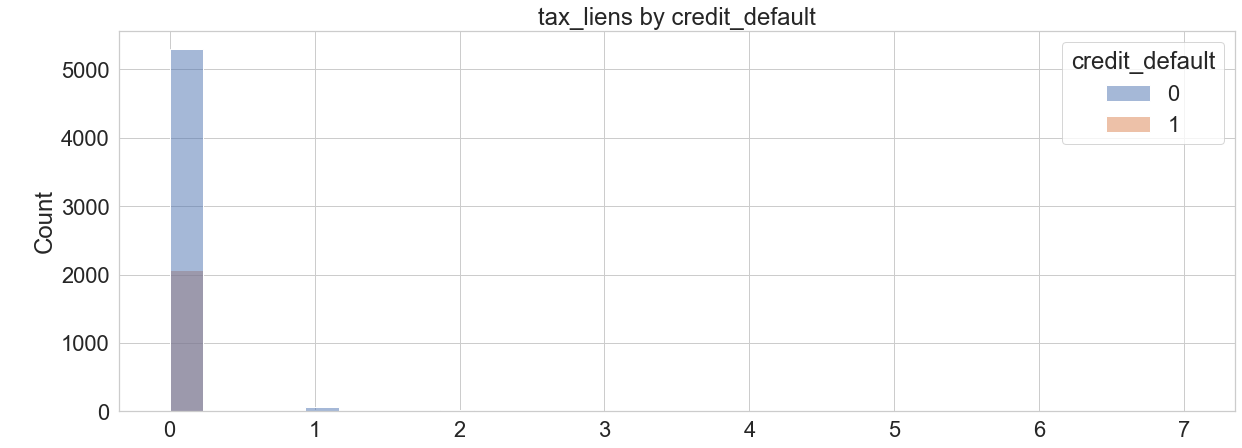

In [2174]:
get_histplot('tax_liens' )

In [2175]:
df.tax_liens.value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: tax_liens, dtype: int64

In [2176]:
df.tax_liens = df.tax_liens.apply(lambda x: int(x))
df_test.tax_liens = df_test.tax_liens.apply(lambda x: int(x))

In [2177]:
get_prob_target('tax_liens')

,tax_liens,credit_default
0,0,0.280342
1,1,0.289157
2,2,0.500000
3,3,0.500000
4,4,0.500000
5,5,0.500000
6,6,0.000000
7,7,0.000000


Видно, что отдельные группы можно объединить. Хотя, они крайне несбалансированы, и большого смысла в этом вряд ли будет.

In [2178]:
bins=[0,
     2,
     6,
     8]

In [2179]:
labels=['0-1',
       '2-5',
       '6-7']

In [2180]:
df.tax_liens = pd.cut(df.tax_liens, bins=bins,labels=labels, right=False)

In [2181]:
df_test.tax_liens = pd.cut(df_test.tax_liens, bins=bins,labels=labels, right=False)

In [2182]:
get_prob_target('tax_liens')

,tax_liens,credit_default
0,0-1,0.28044
1,2-5,0.50000
2,6-7,0.00000


In [2183]:
df.tax_liens.isna().sum()

0

In [2184]:
df_test.tax_liens.isna().sum()

1

In [2185]:
df_test.tax_liens.mode()[0]

'0-1'

In [2186]:
df_test.tax_liens.fillna(df_test.tax_liens.mode()[0], inplace=True)

**maximum_open_credit**             

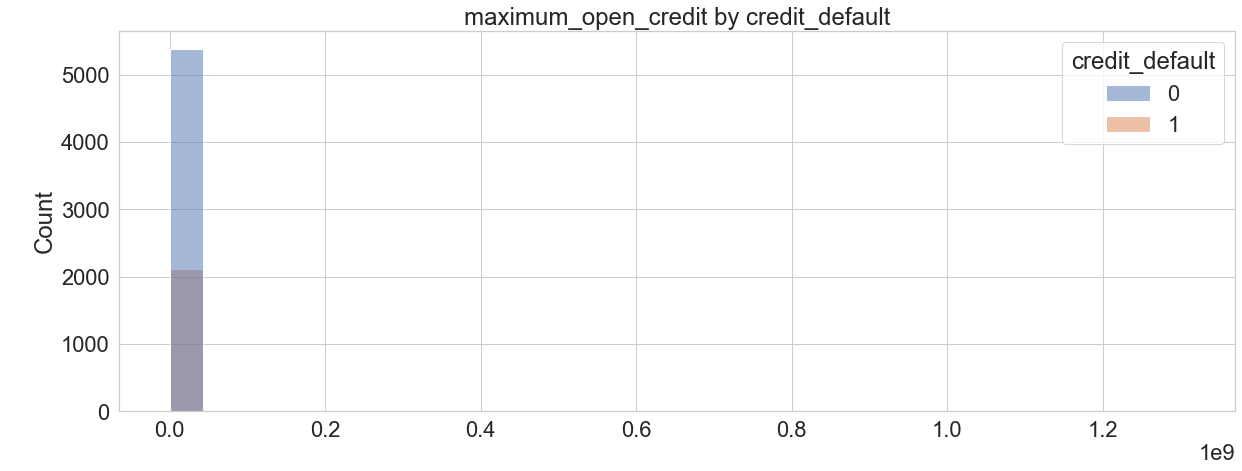

In [2187]:
get_histplot('maximum_open_credit')


In [2188]:
df.maximum_open_credit.describe()

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: maximum_open_credit, dtype: float64

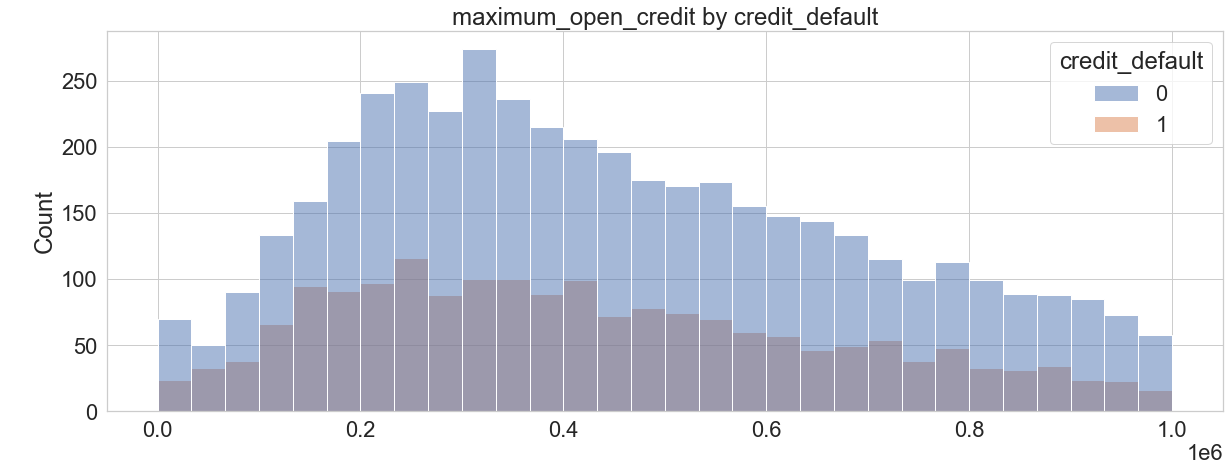

In [2189]:
get_histplot(df=df[df.maximum_open_credit < 1000000],x='maximum_open_credit')

Видим в данных выбросы, сами по себе большие суммы кредита не говорят об аномалиии в данных, но рассмотрим распределение в разрезе целевой переменной.

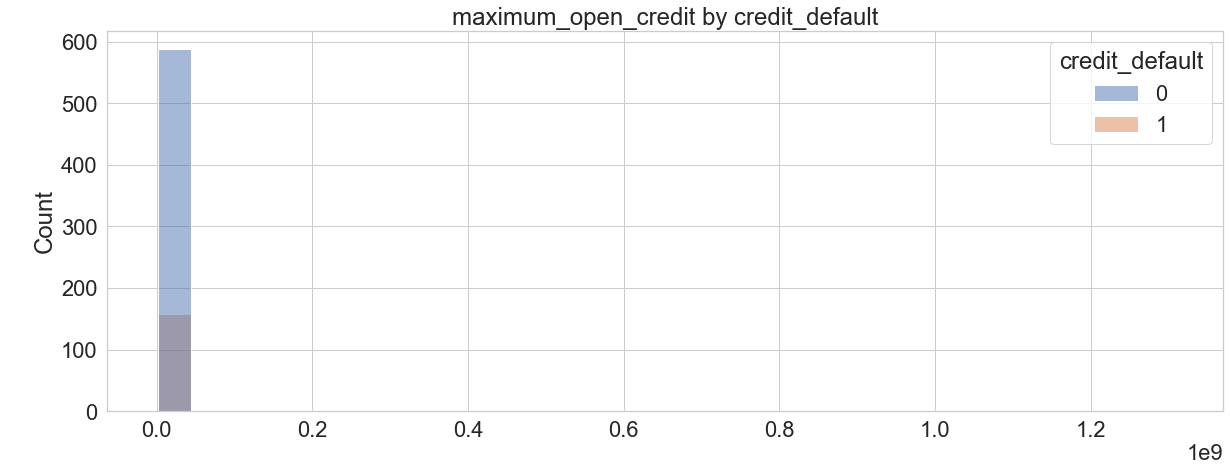

In [2190]:
get_histplot(df=df.query('maximum_open_credit > @df.maximum_open_credit.quantile(0.9)'),x='maximum_open_credit')

In [2191]:
df.query('maximum_open_credit > @df.maximum_open_credit.quantile(0.95)')\
  .agg({TARGET_NAME:np.mean})

credit_default    0.189333
dtype: float64

Очень большие суммы возвращались чаще, но и их значительно реже.

In [2192]:
bins=[0,
     df.maximum_open_credit.quantile(0.25),      
      df.maximum_open_credit.quantile(0.75),
      df.maximum_open_credit.quantile(0.95),
      df.maximum_open_credit.max()+1
     ]

In [2193]:
labels=['less 0.25 quantile',
       '0.25-0.75 quantile',
       '0.75-0.95 quantile',
       'more 0.95 quantile']

In [2194]:
df['maximum_credit_rank'] = pd.cut(df.maximum_open_credit,bins=bins,labels=labels,right=False)

In [2195]:
df_test['maximum_credit_rank'] = pd.cut(df_test.maximum_open_credit,bins=bins,labels=labels,right=False)

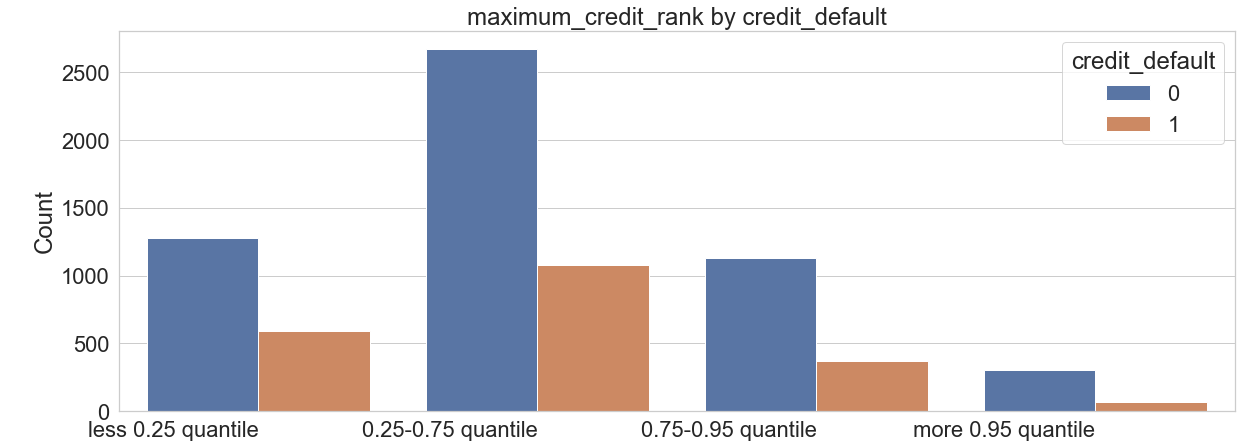

In [2196]:
get_countplot('maximum_credit_rank')

In [2197]:
df.groupby('maximum_credit_rank')\
  .agg({TARGET_NAME:np.mean})

,credit_default
maximum_credit_rank,
less 0.25 quantile,0.316800
0.25-0.75 quantile,0.287200
0.75-0.95 quantile,0.247333
more 0.95 quantile,0.189333


In [2198]:
df.maximum_credit_rank.isna().sum()

0

In [2199]:
#изменим нулевые значения для логаривмирования
df.loc[df.maximum_open_credit == 0, 'maximum_open_credit'] = 0.000001
df_test.loc[df_test.maximum_open_credit == 0, 'maximum_open_credit'] = 0.000001

In [2200]:
df['maximum_open_credit_log'] = df.maximum_open_credit.apply(np.log)

In [2201]:
df_test['maximum_open_credit_log'] = df_test.maximum_open_credit.apply(np.log)

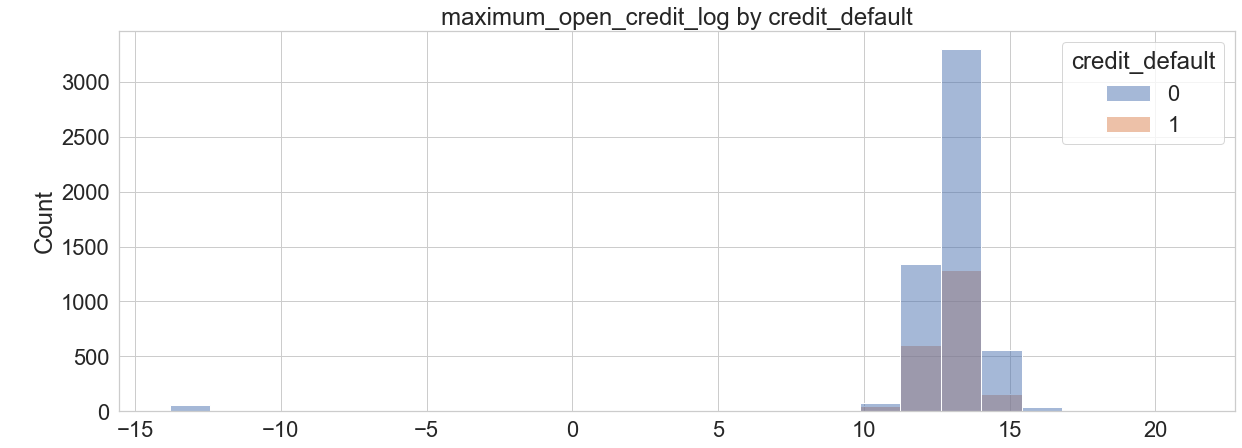

In [2202]:
get_histplot('maximum_open_credit_log',bins=25)

**number_of_credit_problems**

In [2203]:
df.number_of_credit_problems.value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: number_of_credit_problems, dtype: int64

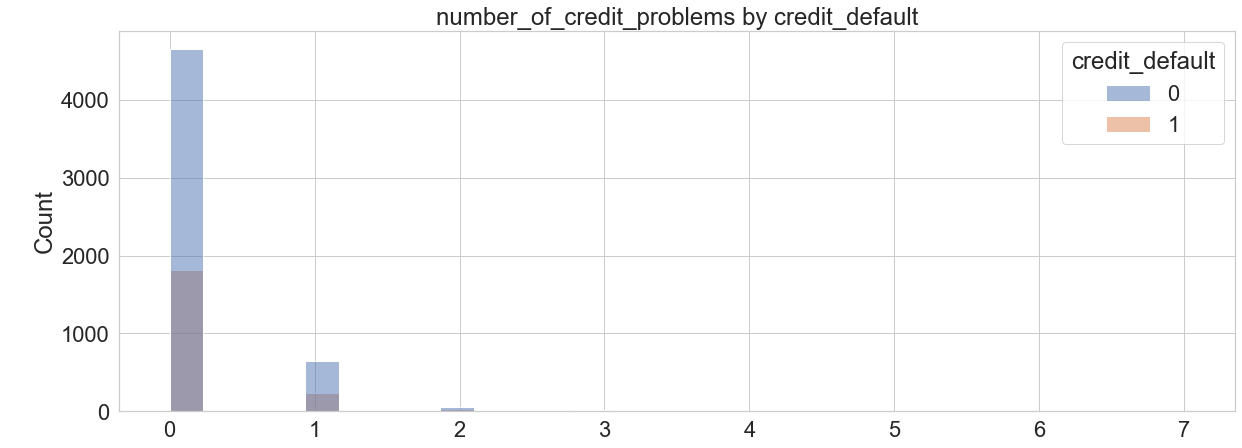

In [2204]:
get_histplot('number_of_credit_problems')

In [2205]:
#переведём переменную в int для дальнейшего отнесения к категорияльным 
df.number_of_credit_problems.apply(int)
df_test.number_of_credit_problems.apply(int)

0       0
1       0
2       0
3       0
4       0
       ..
2495    1
2496    0
2497    0
2498    0
2499    1
Name: number_of_credit_problems, Length: 2500, dtype: int64

In [2206]:
get_prob_target('number_of_credit_problems')

,number_of_credit_problems,credit_default
0,0.0,0.280569
1,1.0,0.273243
2,2.0,0.354839
3,3.0,0.400000
4,4.0,0.666667
5,5.0,0.571429
6,6.0,0.000000
7,7.0,0.000000


Видим схожие попарно схожие значения. Проверим группы.

In [2207]:
problem_and_target_s = df.loc[df.number_of_credit_problems.isin([0,1]), ['id','number_of_credit_problems', TARGET_NAME]].sample(1000)
problem_and_target_s

,id,number_of_credit_problems,credit_default
4977,4977,0.0,0
2337,2337,0.0,0
3880,3880,0.0,1
2486,2486,0.0,1
1951,1951,1.0,0
...,...,...,...
2669,2669,1.0,0
53,53,0.0,0
6505,6505,0.0,1
1186,1186,0.0,1


In [2208]:
table = problem_and_target_s.pivot_table(values='id', index='number_of_credit_problems', columns=TARGET_NAME, aggfunc='count')
table

credit_default,0,1
number_of_credit_problems,,
0.0,632,249
1.0,89,30


In [2209]:
chi2, p, dof, expected = scipy.stats.chi2_contingency(table, correction=False)
p

0.4857809712972687

На разных размерах тест даёт слишком противоречивые показатели. В тестовом режиме объединим схожие показатели.

In [2210]:
bins=[0,
     2,
     4,
     6,
     8]

In [2211]:
labels=[0,
       1,
       2,
       4]

In [2212]:
df.number_of_credit_problems = pd.cut(df.number_of_credit_problems, bins=bins,labels=labels, right=False)

In [2213]:
df_test.number_of_credit_problems = pd.cut(df_test.number_of_credit_problems, bins=bins,labels=labels, right=False)

In [2214]:
get_prob_target('number_of_credit_problems')

,number_of_credit_problems,credit_default
0,0,0.279690
1,1,0.367188
2,2,0.625000
3,4,0.000000


In [2215]:
df.number_of_credit_problems.isna().sum()

0

In [2216]:
df_test.number_of_credit_problems.isna().sum()

1

In [2217]:
df_test.number_of_credit_problems.fillna(df_test.number_of_credit_problems.mode()[0], inplace=True)

**months_since_last_delinquent**    

In [2218]:
df.months_since_last_delinquent.isna().sum()

4081

In [2219]:
df.months_since_last_delinquent

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
7495     NaN
7496    43.0
7497     NaN
7498     NaN
7499     NaN
Name: months_since_last_delinquent, Length: 7500, dtype: float64

Более половины признака пропущенны. Скорее всего имеет бОльший смысл просто удалить признак.
Однако, проверим отдельно в разрезе целевой переменной.


In [2220]:
# df.months_since_last_delinquent.fillna(-9999,inplace=True)

In [2221]:
df.months_since_last_delinquent.loc[~df.months_since_last_delinquent.isna()]

6       73.0
7       18.0
9        6.0
18      40.0
20      44.0
        ... 
7489    35.0
7490    69.0
7491     6.0
7493    58.0
7496    43.0
Name: months_since_last_delinquent, Length: 3419, dtype: float64

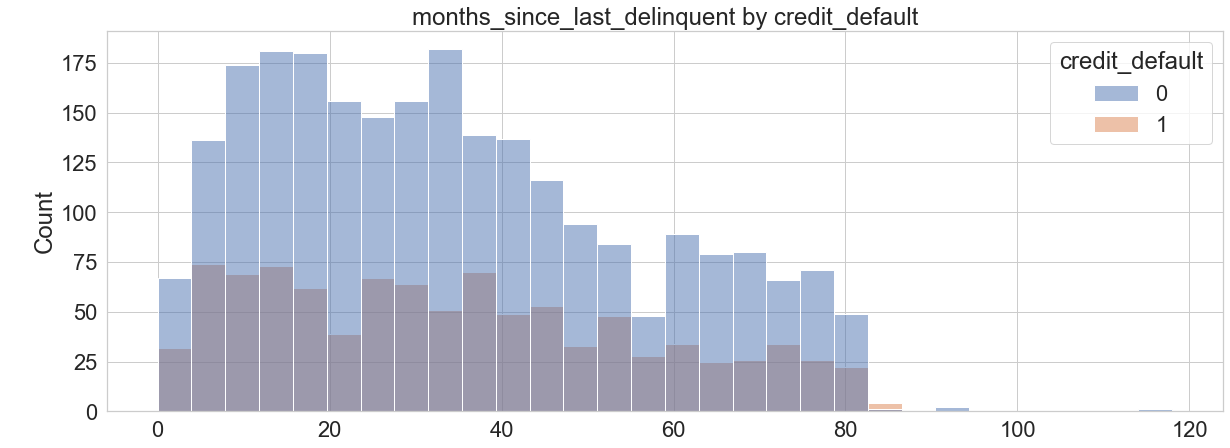

In [2222]:
get_histplot(df=df.loc[~df.months_since_last_delinquent.isna()],x='months_since_last_delinquent')

<AxesSubplot:>

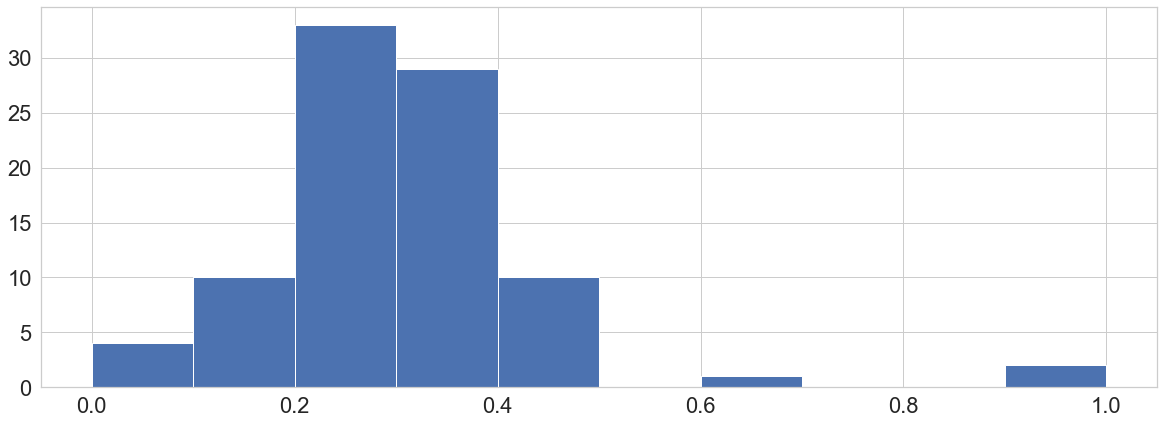

In [2223]:
get_prob_target(df=df.loc[~df.months_since_last_delinquent.isna()],x='months_since_last_delinquent')\
.sort_values(by='credit_default')\
.credit_default.hist()

In [2224]:
# get_histplot(df = df.query('months_since_last_delinquent < 0'),x='months_since_last_delinquent')

In [2225]:
# get_prob_target(df=df.query('months_since_last_delinquent < 0'),x='months_since_last_delinquent')

Видно, что пропущенные не сильно отличаются от общего значения, оставим в таком виде.

In [2226]:
df.corr()['months_since_last_delinquent'].sort_values()

annual_income                  -0.087020
annual_income_log              -0.080221
monthly_debt                   -0.057702
number_of_open_accounts        -0.032740
current_credit_balance         -0.027198
years_of_credit_history        -0.015375
maximum_open_credit_log        -0.011717
credit_score                   -0.004395
maximum_open_credit            -0.003849
current_loan_amount             0.000459
credit_default                  0.002598
id                              0.007262
bankruptcies                    0.162710
months_since_last_delinquent    1.000000
Name: months_since_last_delinquent, dtype: float64

In [2227]:
df.months_since_last_delinquent.fillna(df.months_since_last_delinquent.median(), inplace=True)

In [2228]:
df_test.months_since_last_delinquent.fillna(df.months_since_last_delinquent.median(), inplace=True)

In [2229]:
df.months_since_last_delinquent.isna().sum()

0

<AxesSubplot:xlabel='months_since_last_delinquent', ylabel='Count'>

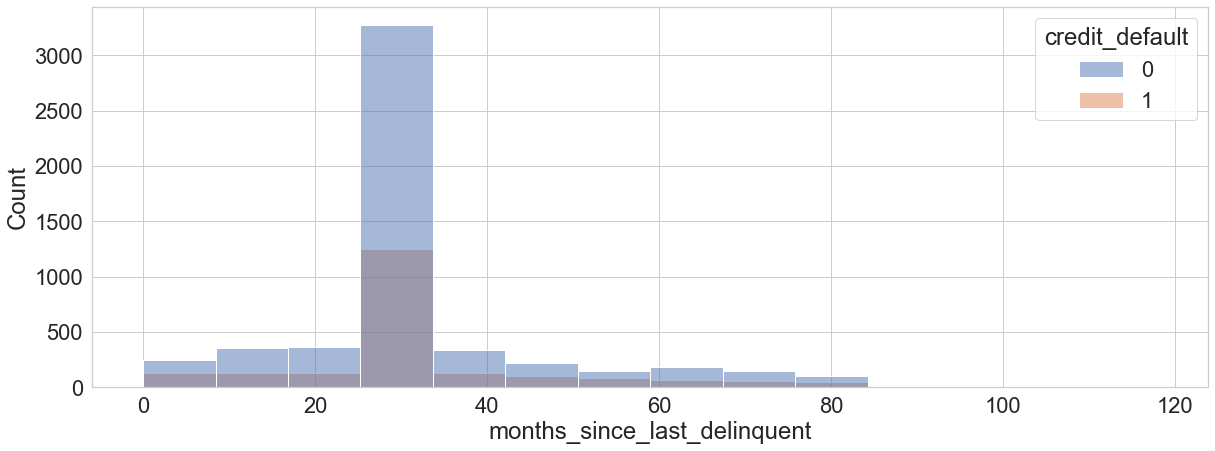

In [2230]:
sns.histplot(x='months_since_last_delinquent', hue=TARGET_NAME, data=df)

***bankruptcies***

In [2231]:
df.bankruptcies.value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: bankruptcies, dtype: int64

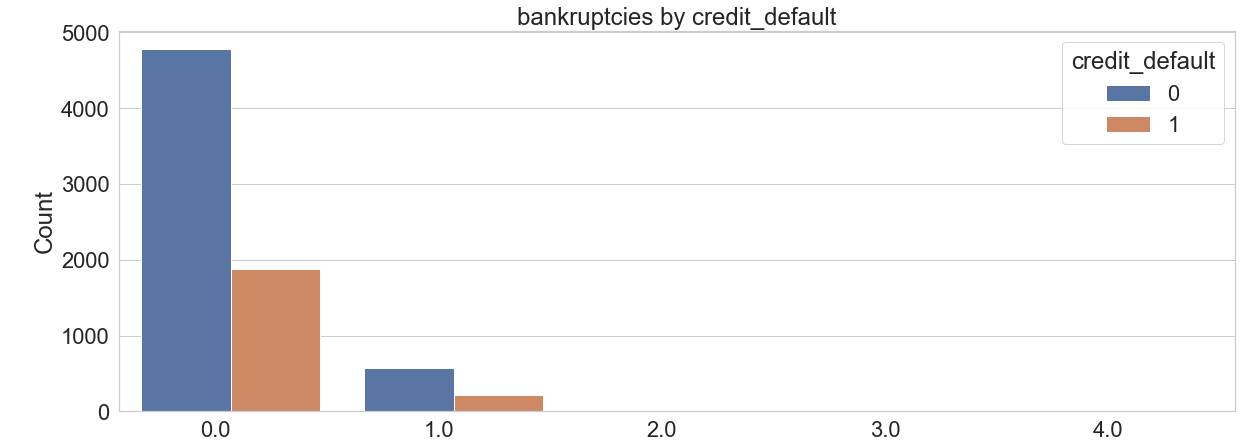

In [2232]:
get_countplot('bankruptcies')

In [2233]:
get_prob_target('bankruptcies')

,bankruptcies,credit_default
0,0.0,0.281982
1,1.0,0.276081
2,2.0,0.354839
3,3.0,0.285714
4,4.0,0.500000


In [2234]:
df.corr()['bankruptcies'].sort_values(ascending=False)

bankruptcies                    1.000000
months_since_last_delinquent    0.109507
years_of_credit_history         0.085699
id                              0.003183
credit_default                  0.001648
current_loan_amount            -0.005987
maximum_open_credit            -0.011650
number_of_open_accounts        -0.019130
maximum_open_credit_log        -0.026384
credit_score                   -0.027488
annual_income_log              -0.064446
annual_income                  -0.070034
monthly_debt                   -0.079579
current_credit_balance         -0.142849
Name: bankruptcies, dtype: float64

<AxesSubplot:xlabel='number_of_credit_problems', ylabel='Percent'>

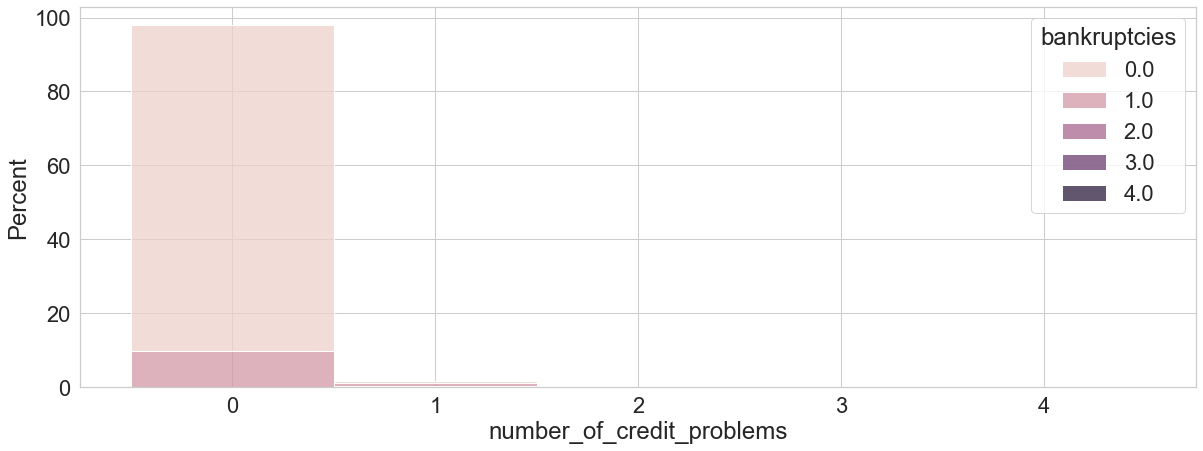

In [2235]:
sns.histplot(x='number_of_credit_problems', hue = 'bankruptcies', multiple='stack',stat='percent', data=df)

In [2236]:
df.bankruptcies.fillna(df.groupby('number_of_credit_problems')['bankruptcies'].transform('max'),inplace=True)

In [2237]:
df_test.bankruptcies.fillna(df.groupby('number_of_credit_problems')['bankruptcies'].transform('max'),inplace=True)

In [2238]:
df.bankruptcies.isna().sum()

0

In [2239]:
df.number_of_credit_problems = df.number_of_credit_problems.apply(int)
df_test.number_of_credit_problems = df_test.number_of_credit_problems.apply(int)

***purpose***

In [2240]:
df.purpose.value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: purpose, dtype: int64

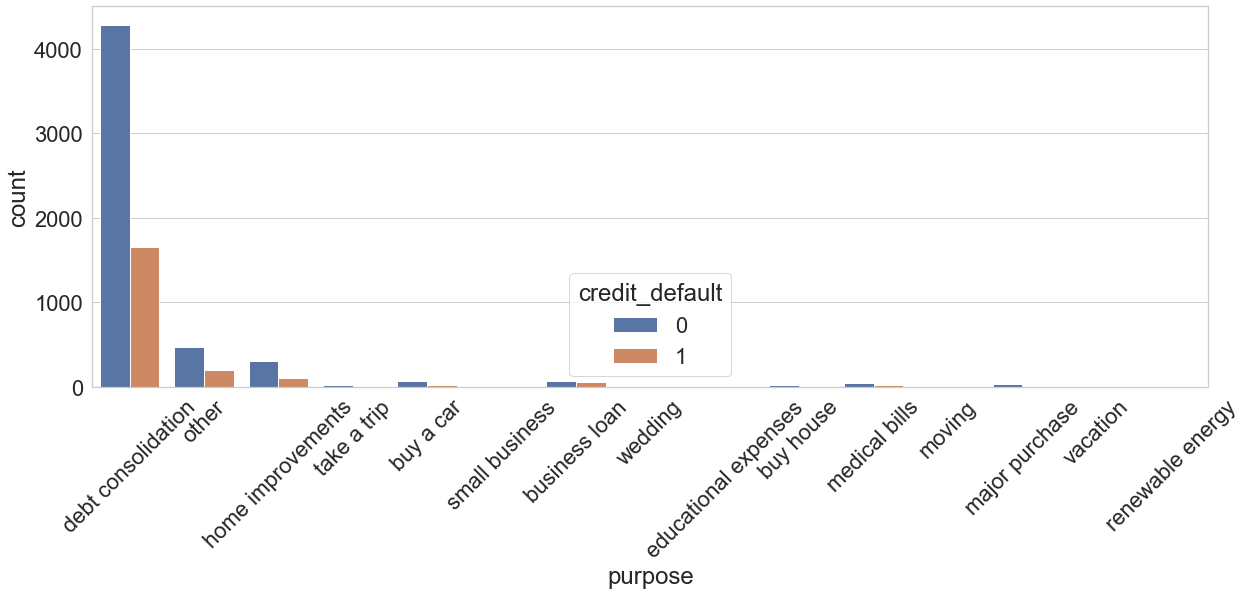

In [2241]:
ax=sns.countplot(x='purpose', hue=TARGET_NAME, data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

In [2242]:
# Сгруппируем по таргету.
get_prob_target('purpose').sort_values(by=TARGET_NAME)

,purpose,credit_default
4,educational expenses,0.100000
8,moving,0.181818
6,major purchase,0.225000
1,buy a car,0.250000
13,vacation,0.250000
5,home improvements,0.262136
2,buy house,0.264706
14,wedding,0.266667
12,take a trip,0.270270
3,debt consolidation,0.278264


In [2243]:
purpose_1 = ['major purchase',
             'vacation',
             'buy a car',
             'home improvements',
             'buy house',
             'wedding',
             'take a trip',
             'debt consolidation'
             ]
purpose_2 = ['other',
            'medical bills']
purpose_3 = ['business loan',
            'small business']
purpose_4 = ['educational expenses',
            'moving']
def group_purpose(df):
    df.loc[df.purpose.isin(purpose_1),'purpose'] = 'various'
    df.loc[df.purpose.isin(purpose_2),'purpose'] = 'other+medical'
    df.loc[df.purpose.isin(purpose_3),'purpose'] = 'business'
    df.loc[df.purpose.isin(purpose_4),'purpose'] = 'education+moving'
   

In [2244]:
group_purpose(df)

In [2245]:
group_purpose(df_test)

In [2246]:
get_prob_target('purpose')

,purpose,credit_default
0,business,0.445161
1,education+moving,0.142857
2,other+medical,0.297554
3,renewable energy,1.000000
4,various,0.276344


In [2247]:
purpose_target = df.loc[df.purpose.isin(['various', 'other+medical']),['id', 'purpose',TARGET_NAME]].sample(2000)
purpose_target

,id,purpose,credit_default
3802,3802,various,0
201,201,various,0
2269,2269,various,1
3334,3334,other+medical,0
2862,2862,various,0
...,...,...,...
3759,3759,various,0
238,238,other+medical,0
3849,3849,various,1
2966,2966,various,0


In [2248]:
pivot = purpose_target.pivot_table(values='id',columns=TARGET_NAME,index='purpose',aggfunc='count')
pivot

credit_default,0,1
purpose,,
other+medical,149,54
various,1300,497


In [2249]:
chi2, p, dof, expected = scipy.stats.chi2_contingency(pivot, correction=False)
p

0.7495084878500292

***term***

In [2250]:
df.term.value_counts()

Short Term    5556
Long Term     1944
Name: term, dtype: int64

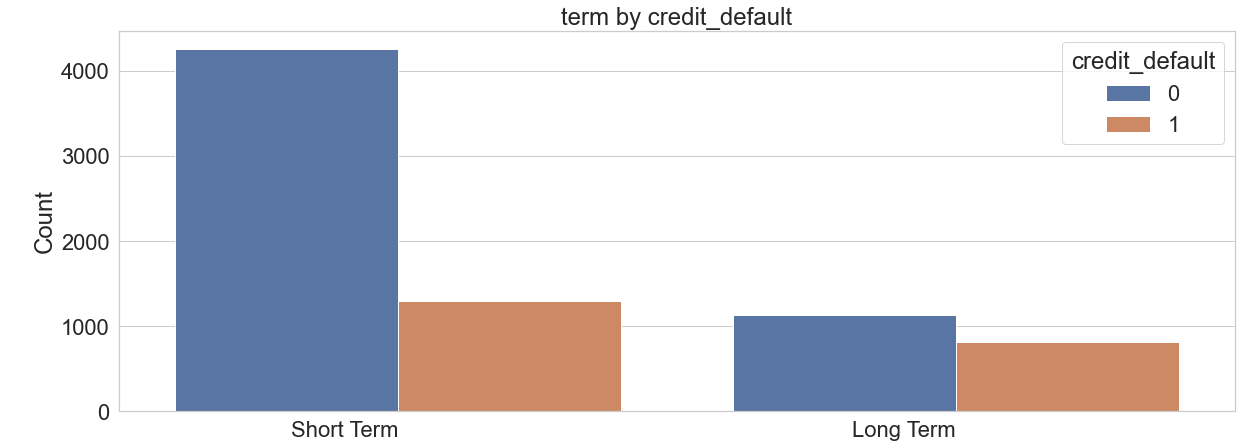

In [2251]:
get_countplot('term')

Видно, что в разделе LongTerm баланс классов изменен.

In [2252]:
term_and_target_s = df.loc[df['term'].isin(['Short Term', 'Long Term']), ['id', 'term', TARGET_NAME]].sample(2000)

In [2253]:
table2 = term_and_target_s.pivot_table(values='id', index='term', columns=TARGET_NAME, aggfunc='count')
table2

credit_default,0,1
term,,
Long Term,298,218
Short Term,1157,327


In [2254]:
chi2, p, dof, expected = scipy.stats.chi2_contingency(table2, correction=False)
p

6.509737814906983e-19

*p-value* ниже порога в 0.05 мы отвергаем гипотезу о равенстве влияние переменной на таргет.

***current_loan_amount***

In [2255]:
df.current_loan_amount.isna().sum()

0

In [2256]:
df.current_loan_amount.describe()

count    7.500000e+03
mean     1.187318e+07
std      3.192612e+07
min      1.124200e+04
25%      1.801690e+05
50%      3.095730e+05
75%      5.198820e+05
max      1.000000e+08
Name: current_loan_amount, dtype: float64

Видим, что значение 1e+08 значительно отличается от среднего и медианы, т.е. является выбросом.

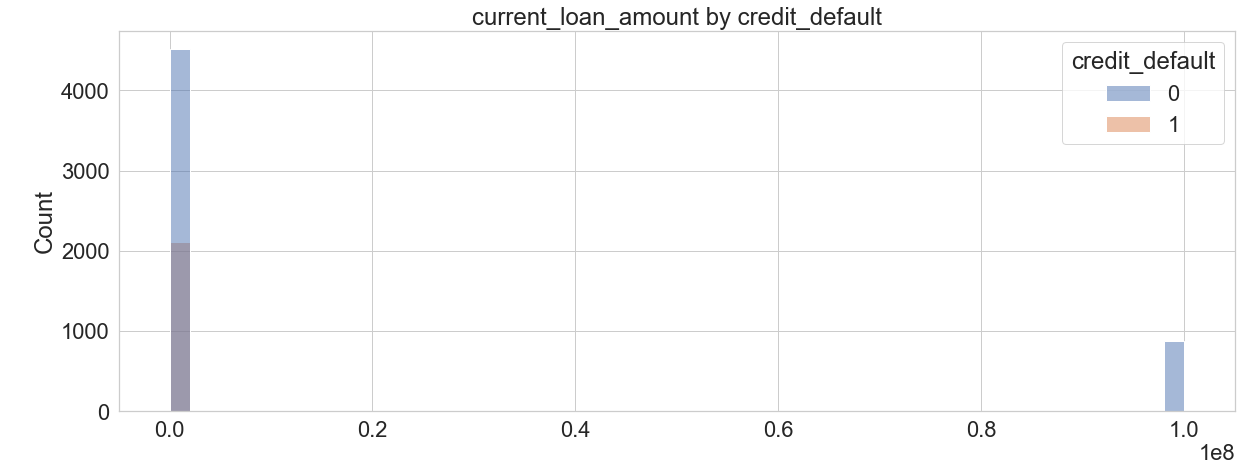

In [2257]:
get_histplot('current_loan_amount',bins=50)

Однако, в этих выбросах 0 показатель нашего таргета. Возможно, это имеет какой-то смысл и оставим его как есть.

In [2258]:
df.loc[df.current_loan_amount < 9000000, 'current_loan_amount'].max()


789030.0

Возможно имеет смысл разбить переменные на группы

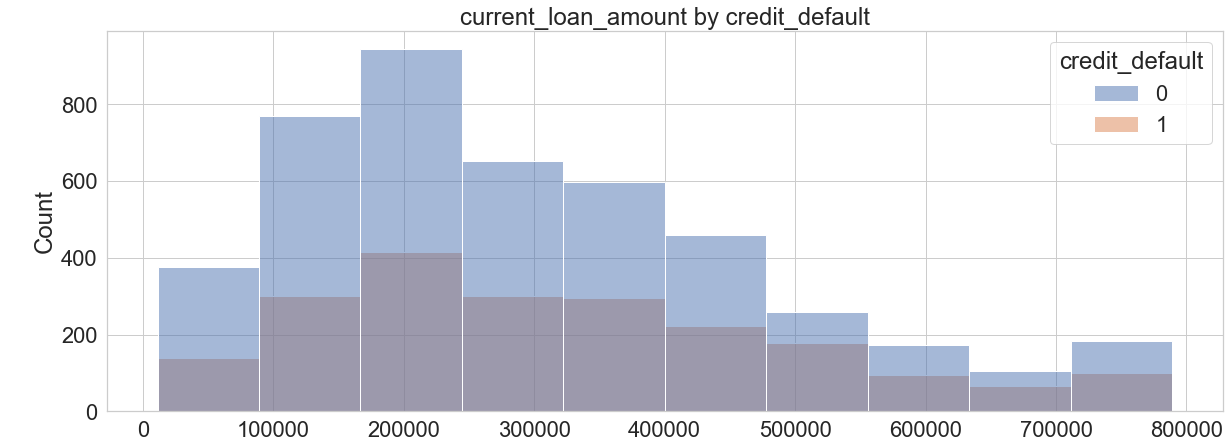

In [2259]:
get_histplot(df=df[df.current_loan_amount < 9000000],x='current_loan_amount',bins=10)

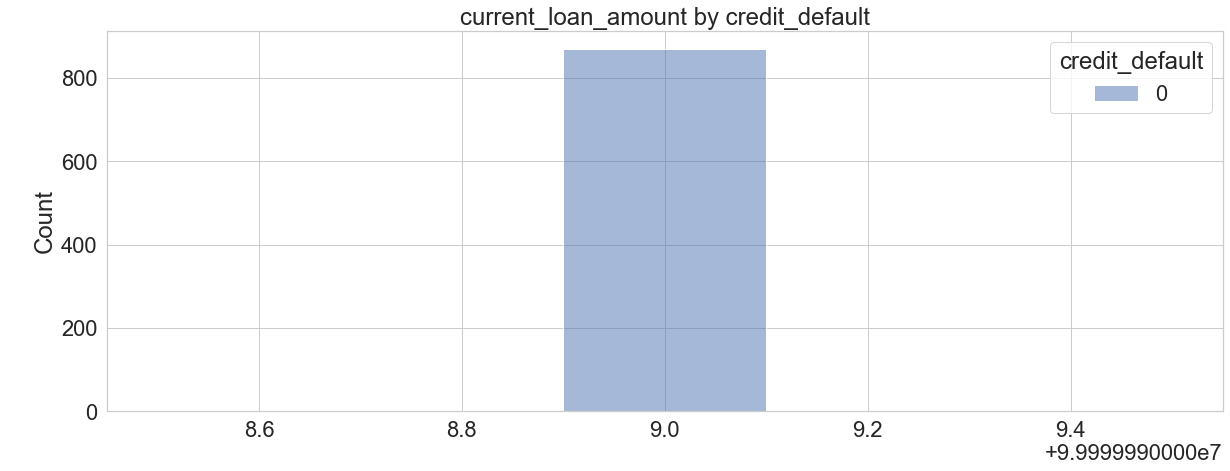

In [2260]:
get_histplot(df=df[df.current_loan_amount > 9000000],x='current_loan_amount',bins=5)

Видим, что эта группа однородна по целевому значения. Возмонжо, имеет смысл оставить её.

In [2261]:
df.loc[df.current_loan_amount > 99999900,'current_loan_amount']

0       99999999.0
2       99999999.0
6       99999999.0
22      99999999.0
27      99999999.0
           ...    
7441    99999999.0
7445    99999999.0
7464    99999999.0
7475    99999999.0
7497    99999999.0
Name: current_loan_amount, Length: 870, dtype: float64

Вариант 2. Посчитаем это аномалием и перепишем в медиану.

In [2262]:
# df.loc[df.current_loan_amount > 99999900,'current_loan_amount'] = df.current_loan_amount.median()

In [2263]:
df.current_loan_amount.describe()

count    7.500000e+03
mean     1.187318e+07
std      3.192612e+07
min      1.124200e+04
25%      1.801690e+05
50%      3.095730e+05
75%      5.198820e+05
max      1.000000e+08
Name: current_loan_amount, dtype: float64

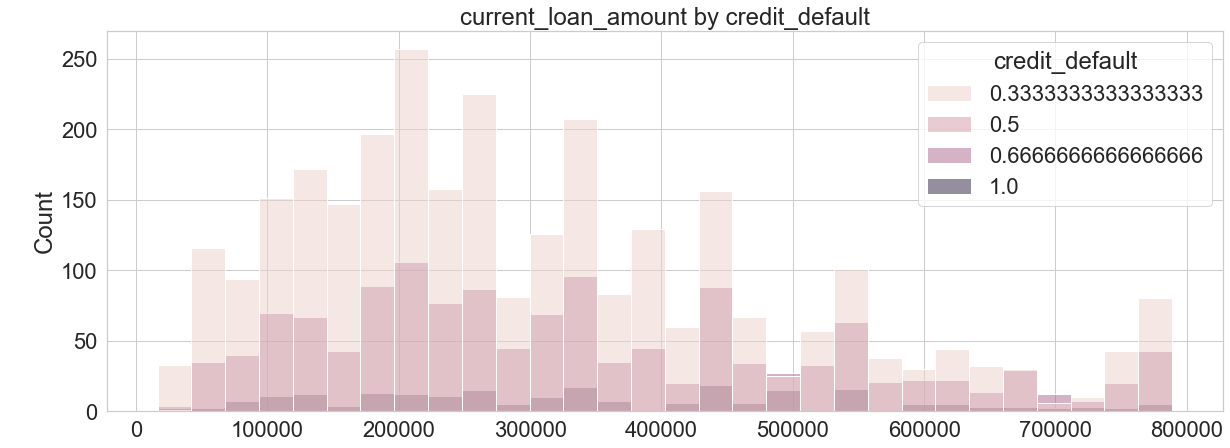

In [2264]:
#построим график распределения высоковероятного таргета( выше 0,5) в связи с текущей суммо кредита
get_histplot(df=df[['current_loan_amount',TARGET_NAME]]\
  .sort_values(by='current_loan_amount')\
  .rolling(3,min_periods=1)\
  .mean()\
  .query('credit_default > 0.3'),x='current_loan_amount')

In [2265]:
bins = [0,
        50000,
        450000,
        600000,
        df.current_loan_amount.max() - 1,
       df.current_loan_amount.max()]

In [2266]:
labels = ["less 50000",
          '50000-450000',
          '450000-800000',
          'more 800000',
          'anormaly'          
          ]

In [2267]:
labels

['less 50000', '50000-450000', '450000-800000', 'more 800000', 'anormaly']

In [2268]:
df['current_loan_amount_rank'] = pd.cut(df.current_loan_amount, bins=bins,labels=labels)

In [2269]:
df_test['current_loan_amount_rank'] = pd.cut(df_test.current_loan_amount, bins=bins,labels=labels)

In [2270]:
get_prob_target('current_loan_amount_rank')

,current_loan_amount_rank,credit_default
0,less 50000,0.259542
1,50000-450000,0.304574
2,450000-800000,0.397203
3,more 800000,0.359867
4,anormaly,0.000000


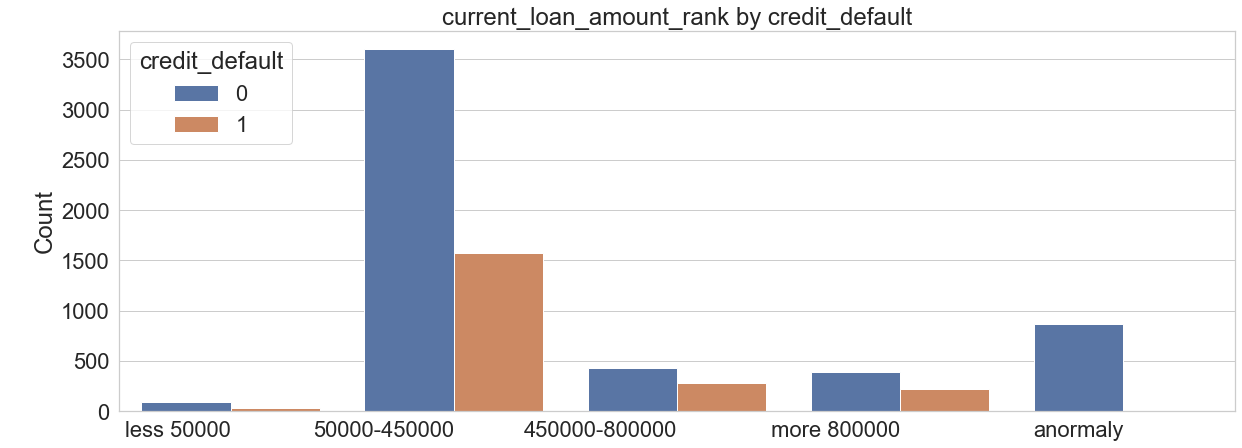

In [2271]:
get_countplot('current_loan_amount_rank')

Ввиду высокой скоррелированности current_loan_amount и annual_income, ввёдем фичу отношение кредита к доходу.

In [2272]:
df['proportion_current_loan_annual']=df.current_loan_amount / df.annual_income
df_test['proportion_current_loan_annual']=df_test.current_loan_amount / df.annual_income

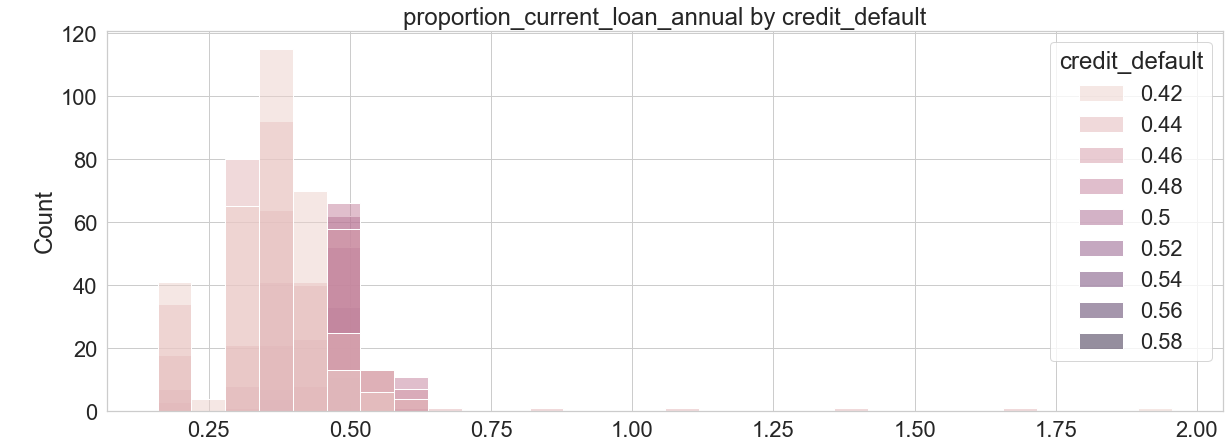

In [2273]:
#построим график распределения высоковероятного таргета( выше 0,5) в связи с новой фичёй
get_histplot(df=df[['proportion_current_loan_annual',TARGET_NAME]]\
  .sort_values(by='proportion_current_loan_annual')\
  .rolling(50,min_periods=1)\
  .mean()\
  .query('credit_default > 0.4'),x='proportion_current_loan_annual')

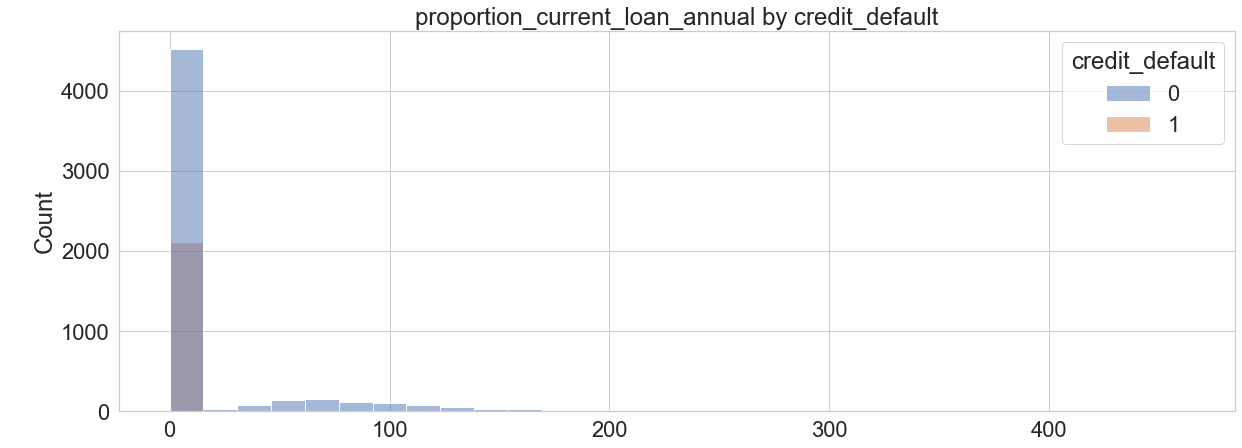

In [2274]:
get_histplot('proportion_current_loan_annual')

In [2275]:
# bins=[-1,
#      0,
#      0.2,
#      0.4,
#      df.proportion_current_loan_annual.max()]

In [2276]:
# labels=[
#     '-1',
#     '0.2',
#     '0.4',
#     'more 0.4'
# ]

In [2277]:
# df['proportion_current_loan_annual_rank'] = pd.cut(df.proportion_current_loan_annual, bins=bins,labels=labels)

In [2278]:
# get_prob_target('proportion_current_loan_annual_rank')

***current_credit_balance***

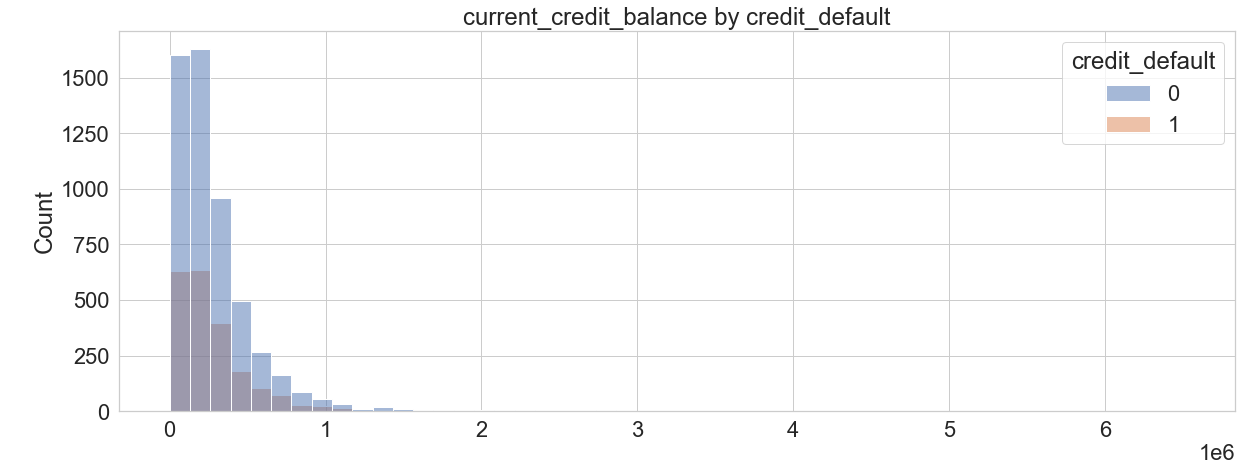

In [2279]:
get_histplot('current_credit_balance',bins=50)

array([[<AxesSubplot:title={'center':'current_credit_balance'}>,
        <AxesSubplot:title={'center':'credit_default'}>]], dtype=object)

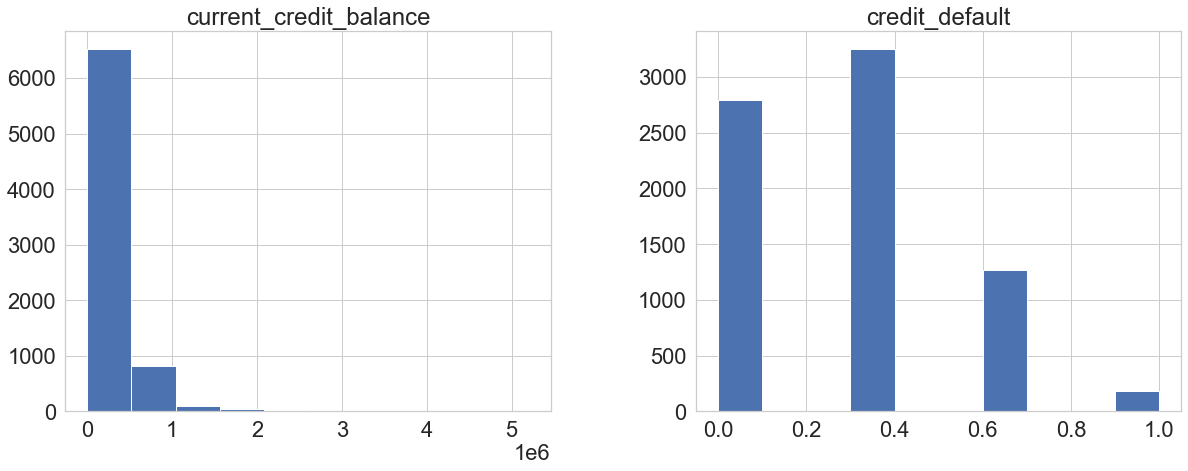

In [2280]:
df[['current_credit_balance',TARGET_NAME]]\
  .sort_values(by='current_credit_balance')\
  .rolling(3,min_periods=1)\
  .mean().hist()

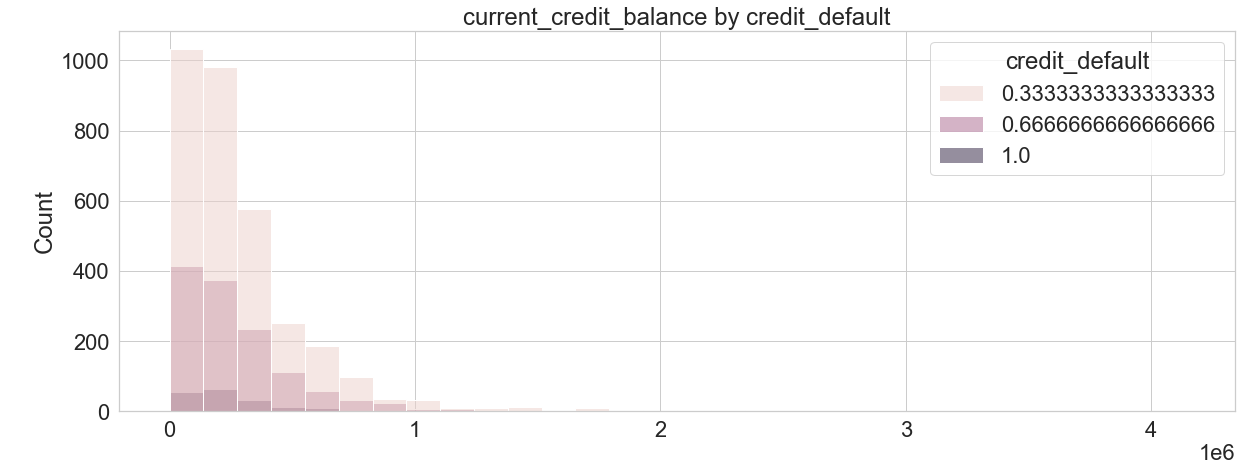

In [2281]:
#построим график распределения высоковероятного таргета( выше 0,5) в связи с текущей суммо кредита
get_histplot(df=df[['current_credit_balance',TARGET_NAME]]\
  .sort_values(by='current_credit_balance')\
  .rolling(3,min_periods=1)\
  .mean()\
  .query('credit_default > 0.3'),x='current_credit_balance')

In [2282]:
bins = [-1,
        0,
        1000000,
        df.current_credit_balance.max()]

In [2283]:
labels = ['0',
         'less 1.000.000',
         'more 1.000.000']

In [2284]:
df['current_credit_balance_rank'] = pd.cut(df.current_credit_balance, bins=bins,labels=labels)
df_test['current_credit_balance_rank'] = pd.cut(df_test.current_credit_balance, bins=bins,labels=labels)

In [2285]:
get_prob_target('current_credit_balance_rank')

,current_credit_balance_rank,credit_default
0,0,0.169811
1,less 1.000.000,0.284061
2,more 1.000.000,0.223404


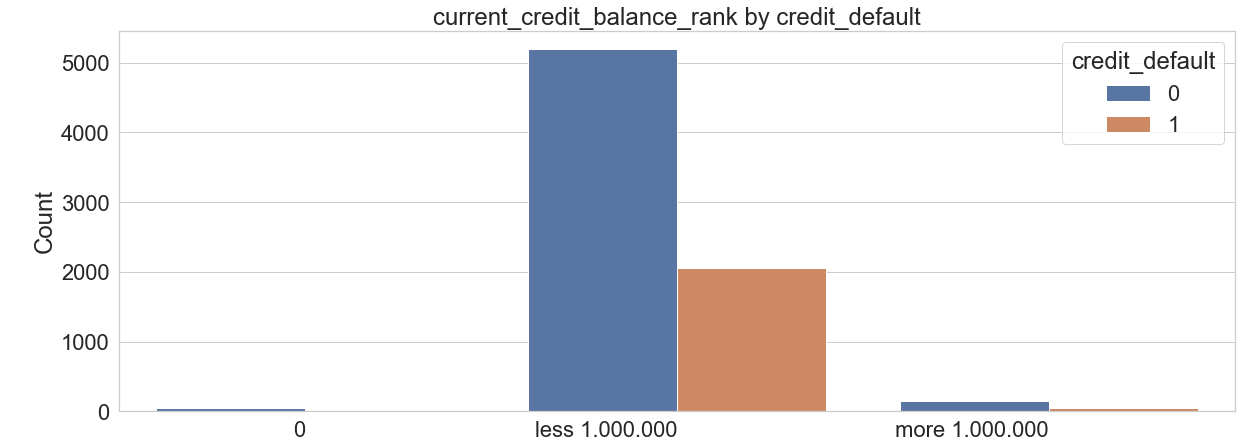

In [2286]:
get_countplot('current_credit_balance_rank')

In [2287]:
# df.drop(columns='current_credit_balance_rank',inplace=True)

***credit_score***

In [2288]:
df.credit_score.describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: credit_score, dtype: float64

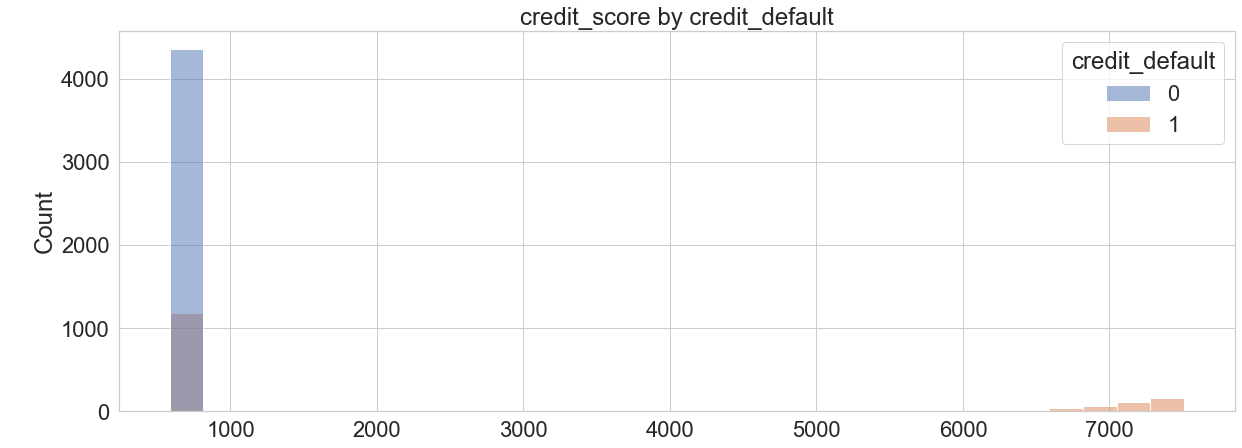

In [2289]:
get_histplot('credit_score')

Корреляция с тагретом, что хорошо для классификации, но не очень хорошо для заполнения пропущенных данных.

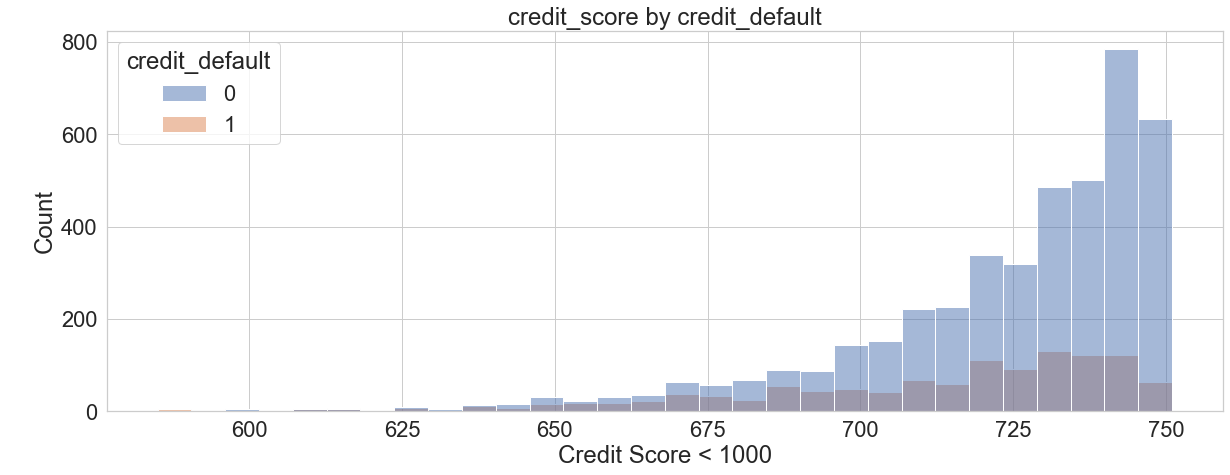

In [2290]:
get_histplot(df=df[df.credit_score < 1000],x='credit_score',xlabel='Credit Score < 1000')

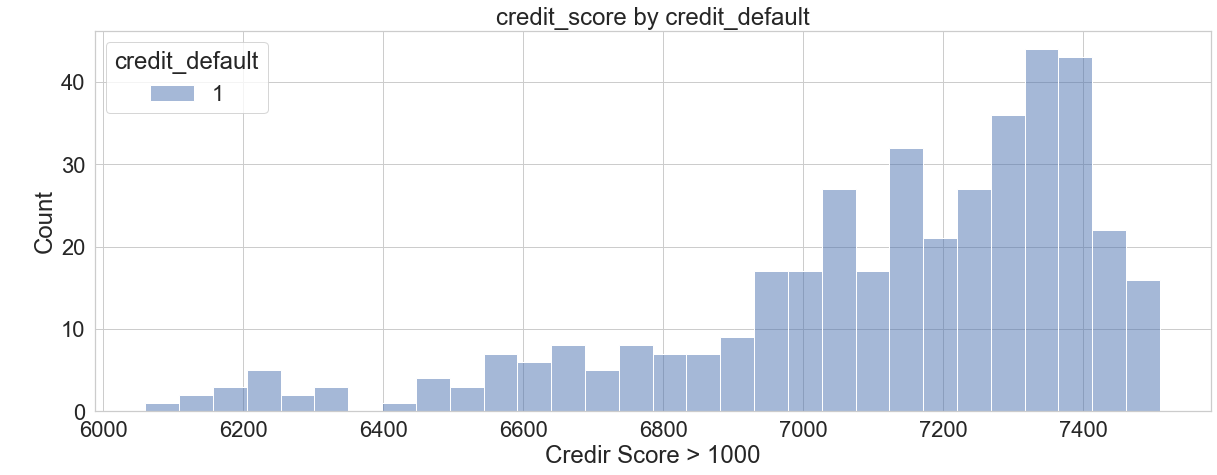

In [2291]:
get_histplot(df=df.query('credit_score > 1000'),x='credit_score',xlabel='Credir Score > 1000')

Мы видим, что показатели выше 1000, которые с одной стороны больше похожи на ошибку, но вних также содержатся только один признак (credit_default==1). Оставим для модели как признак.

Вариант 1. Зададим единное значение

In [2292]:
df.query('credit_score < 1000').credit_score.max()

751.0

In [2293]:
df.loc[df.credit_score > 1000, 'credit_score'] = -1
df_test.loc[df_test.credit_score > 1000, 'credit_score'] = -1

Вариант 2. Посчитаем ошибкой записи и поделим на 1000.

In [2294]:
# df.loc[df.credit_score > 1000, 'credit_score'] = df.query('credit_score > 1000').credit_score.apply(lambda x: x / 10)
# df_test.loc[df_test.credit_score > 1000, 'credit_score'] = df_test.query('credit_score > 1000').credit_score.apply(lambda x: x / 10)

In [2295]:
df.corr()['credit_score'].sort_values(ascending=False)

credit_score                      1.000000
current_loan_amount               0.131370
proportion_current_loan_annual    0.108755
annual_income_log                 0.050198
annual_income                     0.041801
years_of_credit_history           0.026937
bankruptcies                      0.016170
maximum_open_credit               0.013716
current_credit_balance            0.005055
months_since_last_delinquent     -0.000347
maximum_open_credit_log          -0.009928
monthly_debt                     -0.012219
number_of_open_accounts          -0.021626
id                               -0.040440
credit_default                   -0.466913
Name: credit_score, dtype: float64

In [2296]:
df.loc[df.credit_score > 0]

,home_ownership,annual_income,years_in_current_job,tax_liens,number_of_open_accounts,years_of_credit_history,maximum_open_credit,number_of_credit_problems,months_since_last_delinquent,bankruptcies,...,credit_score,credit_default,id,annual_income_log,years_credit_history_rank,maximum_credit_rank,maximum_open_credit_log,current_loan_amount_rank,proportion_current_loan_annual,current_credit_balance_rank
0,Home,482087.0,10+ years,0-1,11.0,26.3,685960.0,0,32.0,1.0,...,749.0,0,0,13.085880,10 - 30,0.25-0.75 quantile,13.438575,anormaly,207.431437,less 1.000.000
1,Home,1025487.0,10+ years,0-1,15.0,15.3,1181730.0,0,32.0,0.0,...,737.0,1,1,13.840678,10 - 30,0.75-0.95 quantile,13.982490,50000-450000,0.258383,less 1.000.000
2,Home,751412.0,8 years,0-1,11.0,35.0,1182434.0,0,32.0,0.0,...,742.0,0,2,13.529709,more 30,0.75-0.95 quantile,13.983086,anormaly,133.082781,less 1.000.000
3,Home,805068.0,6 years,0-1,8.0,22.5,147400.0,0,32.0,1.0,...,694.0,0,3,13.598682,10 - 30,less 0.25 quantile,11.900905,50000-450000,0.150790,less 1.000.000
4,Rent,776264.0,8 years,0-1,13.0,13.6,385836.0,0,32.0,0.0,...,719.0,0,4,13.562248,10 - 30,0.25-0.75 quantile,12.863168,50000-450000,0.162110,less 1.000.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7490,Home,1368000.0,10+ years,0-1,20.0,26.7,897842.0,0,69.0,0.0,...,688.0,1,7490,14.128860,10 - 30,0.75-0.95 quantile,13.707749,more 800000,0.499744,less 1.000.000
7491,Home,2833185.0,6 years,0-1,18.0,21.3,280170.0,0,6.0,0.0,...,704.0,0,7491,14.856912,10 - 30,0.25-0.75 quantile,12.543152,50000-450000,0.154386,less 1.000.000
7493,Rent,1257610.0,8 years,0-1,14.0,16.5,821480.0,0,58.0,0.0,...,676.0,1,7493,14.044724,10 - 30,0.75-0.95 quantile,13.618863,50000-450000,0.356273,less 1.000.000
7495,Rent,402192.0,< 1 year,0-1,3.0,8.5,107866.0,0,32.0,0.0,...,697.0,0,7495,12.904685,less 10,less 0.25 quantile,11.588645,50000-450000,0.321637,less 1.000.000


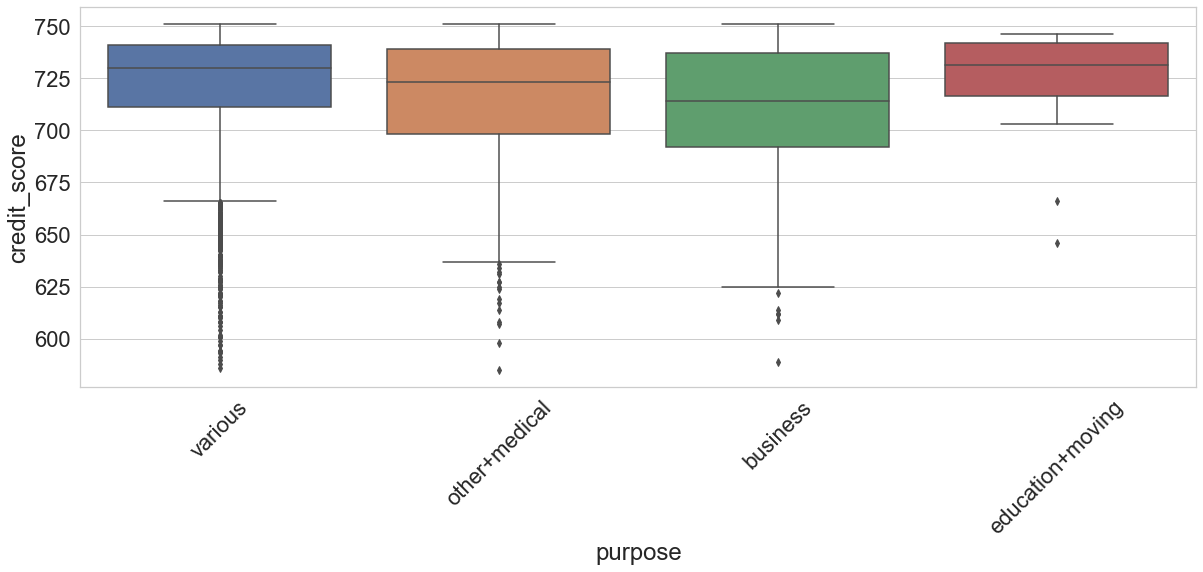

In [2297]:
ax=sns.boxplot(data=df.loc[df.credit_score > 0], x='purpose', y='credit_score')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45);

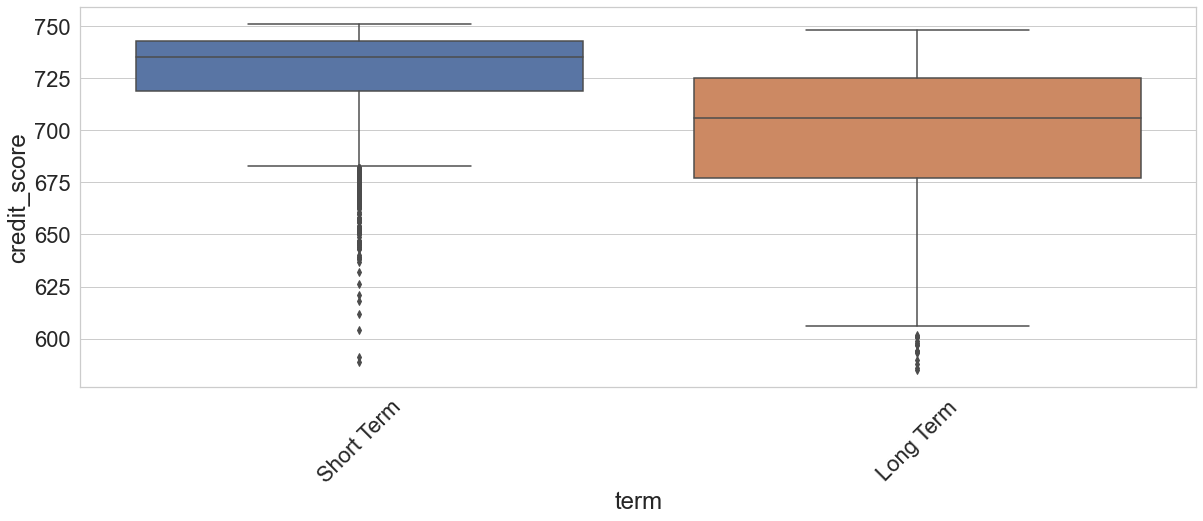

In [2298]:
ax=sns.boxplot(data=df.loc[df.credit_score > 0], x='term', y='credit_score')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45);

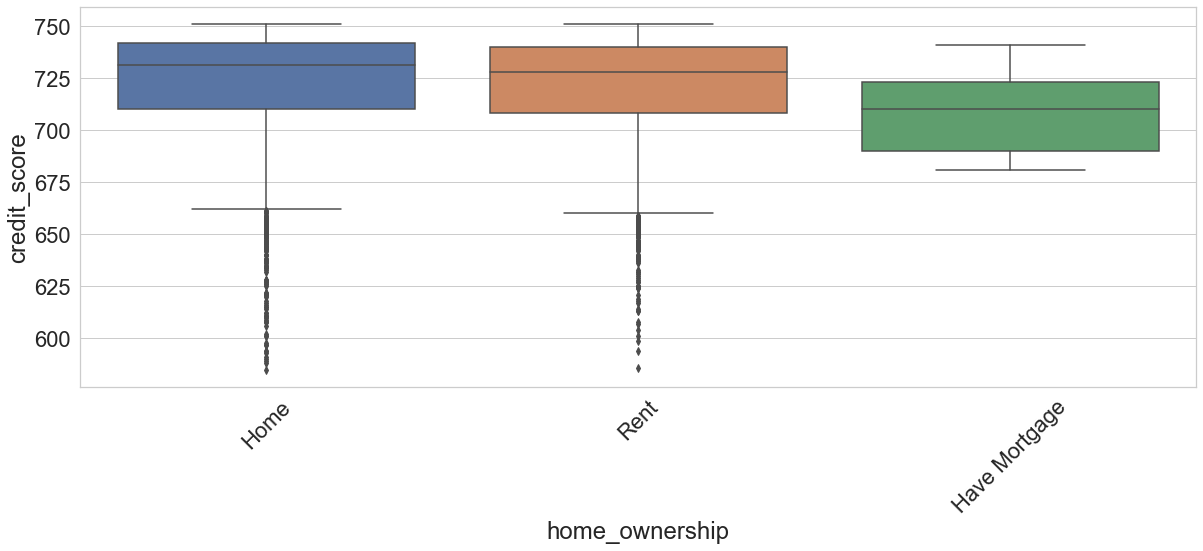

In [2299]:
ax=sns.boxplot(data=df.loc[df.credit_score > 0], x='home_ownership', y='credit_score')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45);

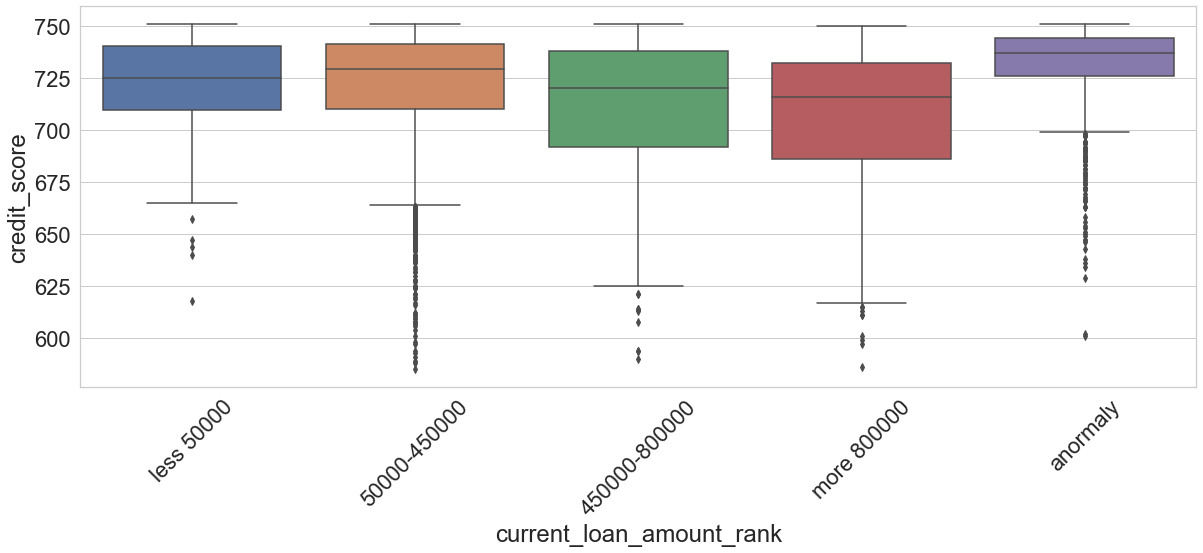

In [2300]:
ax=sns.boxplot(data=df.loc[df.credit_score > 0], x='current_loan_amount_rank', y='credit_score')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45);

In [2301]:
df.credit_score.isna().sum()

1557

In [2302]:
df.loc[df.credit_score.isna(),'credit_score'].isna().sum()

1557

Вариант 1. Заполним медианой по наиболее скоррелированной переменой и медианнойю

In [2303]:
credit_score_mean_grby=df.groupby(['current_loan_amount','term'])['credit_score'].transform('median')
credit_score_mean_grby_test=df_test.groupby(['current_loan_amount','term'])['credit_score'].transform('median')

In [2304]:
df.credit_score.fillna(credit_score_mean_grby, inplace=True)
df_test.credit_score.fillna(credit_score_mean_grby_test, inplace=True)

In [2305]:
df.credit_score.isna().sum()

1223

In [2306]:
df_test.credit_score.isna().sum()

471

ост. строчки, к-ые не попали ни в term, ни в purpose, заменим на общую медиану.

In [2307]:
df.credit_score.fillna(df.credit_score.median(), inplace=True)
df_test.credit_score.fillna(df_test.credit_score.median(), inplace=True)

Вариант 2. Заполним пропушенные обученными данными.

In [2308]:
# temp_df = pd.get_dummies(df)

In [2309]:
# X_ = temp_df.query('(credit_score > 0) and (~@pd.isna(credit_score))')
# X_t = df_test.query('(credit_score > 0) and (~@pd.isna(credit_score))')

In [2310]:
# y_ = X_.credit_score

In [2311]:
# trianX_ = X_.drop(columns='credit_score')


In [2312]:
# rfr = RandomForestRegressor(random_state=42)

In [2313]:
# rfr.fit(trianX_, y_)

In [2314]:
# testX_ = temp_df.query('@pd.isna(credit_score)')
# testX_ = pd.get_dummies(testX_)
# testX_ = testX_.drop(columns='credit_score')

In [2315]:
# pred_credit_score = rfr.predict(testX_)

In [2316]:
# temp_df =  pd.DataFrame(df.loc[df.credit_score.isna()])
# temp_df['pred'] = pred_credit_score
# temp_df.pred.isna().sum()

In [2317]:
# df.credit_score.fillna(temp_df.pred, inplace=True)
# df.credit_score.isna().sum()

In [2318]:
# df.loc[df.credit_score.isna(), 'credit_score'] = -1

Разделим переменнцю на ранги

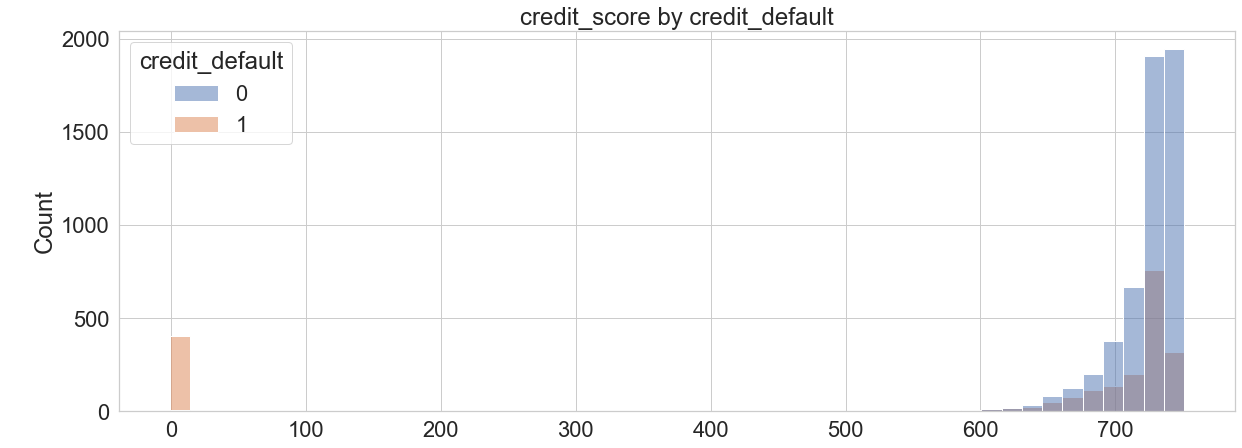

In [2319]:
get_histplot('credit_score',bins=50)

In [2320]:
df[df.credit_score < 1000].credit_score.max()

751.0

In [2321]:
bins = [-2,
        0,
        700,        
        740,
        750,
        df.credit_score.max()
       ]

In [2322]:
labels = ['-1',         
          'less 700',
         '700-740',
         '740-750',
         'more 750'
         ]

In [2323]:
df['credit_score_rank'] = pd.cut(df.credit_score,bins=bins,labels=labels)
df_test['credit_score_rank'] = pd.cut(df_test.credit_score,bins=bins,labels=labels)

In [2324]:
get_prob_target('credit_score_rank')

,credit_score_rank,credit_default
0,-1,0.980535
1,less 700,0.354454
2,700-740,0.253685
3,740-750,0.126626
4,more 750,0.049180


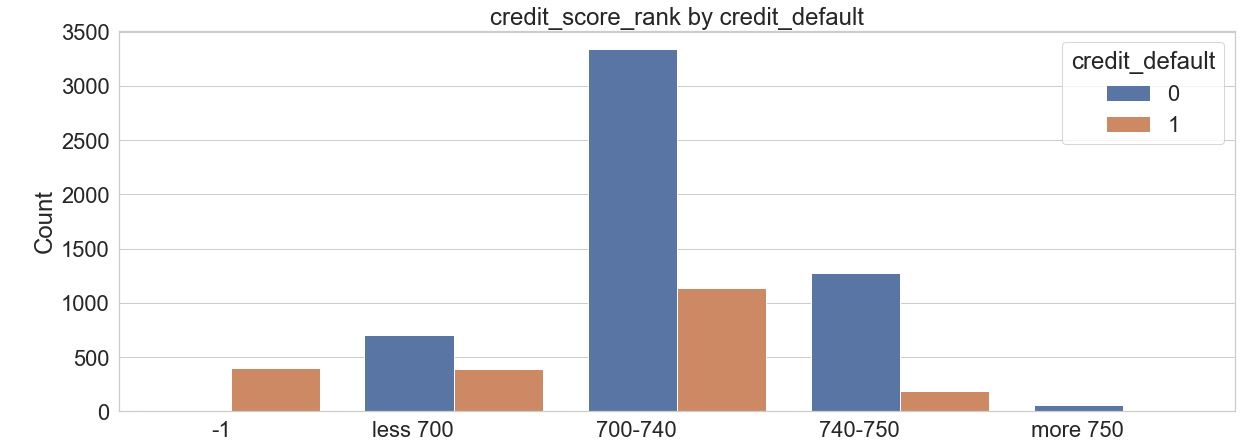

In [2325]:
get_countplot('credit_score_rank')

***number_of_open_accounts***

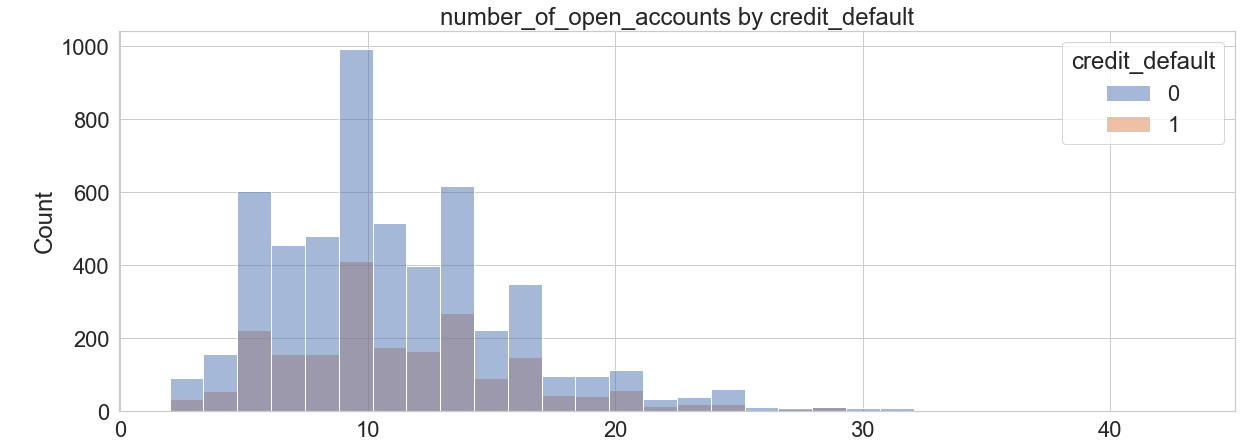

In [2326]:
get_histplot('number_of_open_accounts',bins=30)

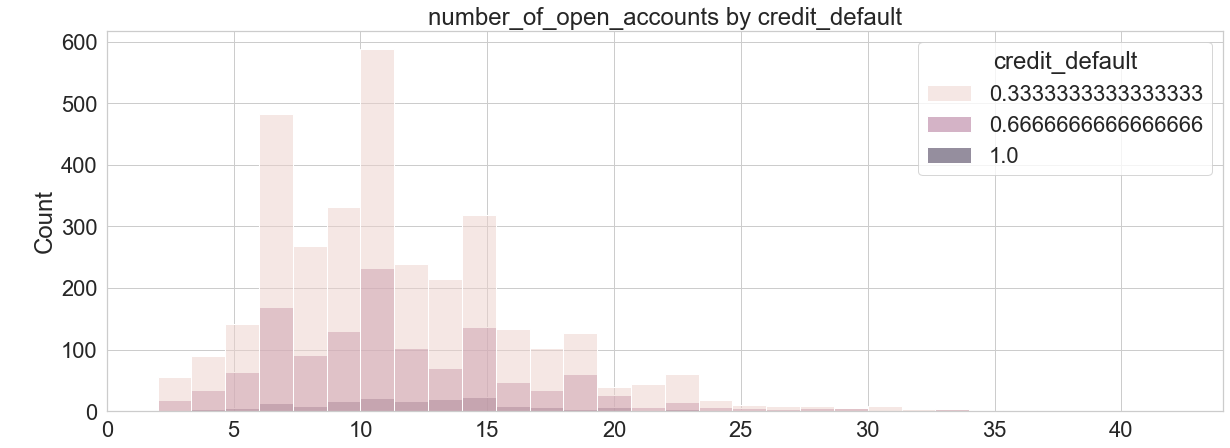

In [2327]:
#построим график распределения высоковероятного таргета( выше 0,5) в связи с текущей суммо кредита
get_histplot(df=df[['number_of_open_accounts',TARGET_NAME]]\
  .sort_values(by='number_of_open_accounts')\
  .rolling(3,min_periods=1)\
  .mean()\
  .query('credit_default > 0.28'),x='number_of_open_accounts')

In [2328]:
df.number_of_open_accounts.apply(int)
df_test.number_of_open_accounts.apply(int)

0        9
1        6
2       10
3       16
4       11
        ..
2495    14
2496    15
2497    48
2498    14
2499    12
Name: number_of_open_accounts, Length: 2500, dtype: int64

In [2329]:
temp_df = get_prob_target('number_of_open_accounts').sort_values(by=TARGET_NAME)
temp_df

,number_of_open_accounts,credit_default
38,43.0,0.000000
36,41.0,0.000000
34,37.0,0.000000
24,26.0,0.083333
30,32.0,0.166667
29,31.0,0.166667
28,30.0,0.181818
22,24.0,0.220000
6,8.0,0.247649
1,3.0,0.252632


In [2330]:
bin1 = list(temp_df.query('credit_default < 0.1')['number_of_open_accounts'])
bin2 = list(temp_df.query('credit_default > 0.1 and credit_default < 0.3')['number_of_open_accounts'])
bin3 = list(temp_df.query('credit_default > 0.3 and credit_default < 0.5')['number_of_open_accounts'])
bin4 = list(temp_df.query('credit_default >= 0.5 and credit_default < 0.8')['number_of_open_accounts'])
bin5 = list(temp_df.query('credit_default > 0.8')['number_of_open_accounts'])

In [2331]:
def group_number_open(df):
    df.loc[df.number_of_open_accounts.isin(bin1),'number_of_open_accounts'] = '0'
    df.loc[df.number_of_open_accounts.isin(bin2),'number_of_open_accounts'] = '1'
    df.loc[df.number_of_open_accounts.isin(bin3),'number_of_open_accounts'] = '2'
    df.loc[df.number_of_open_accounts.isin(bin4),'number_of_open_accounts'] = '3'
    df.loc[df.number_of_open_accounts.isin(bin5),'number_of_open_accounts'] = '4'

In [2332]:
group_number_open(df)
group_number_open(df_test)

In [2333]:
get_prob_target('number_of_open_accounts')

,number_of_open_accounts,credit_default
0,0,0.062500
1,1,0.274014
2,2,0.320851
3,3,0.500000
4,4,1.000000


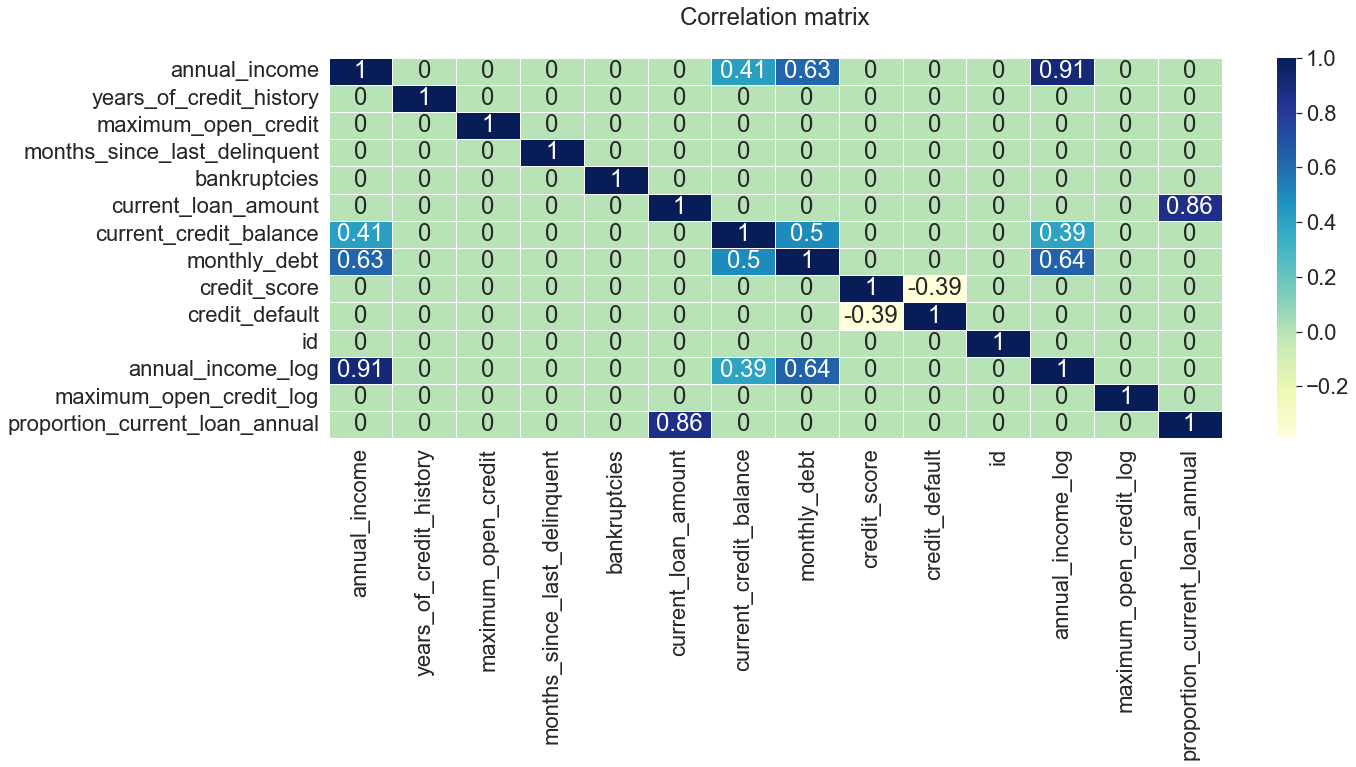

In [2334]:
#матрица корреляции, получившхся некатегориальных признаков
corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='YlGnBu')

plt.title('Correlation matrix\n')
plt.show()

***Подготовим данные для CatBoost***

In [2335]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   home_ownership                  7500 non-null   object  
 1   annual_income                   7500 non-null   float64 
 2   years_in_current_job            7500 non-null   object  
 3   tax_liens                       7500 non-null   category
 4   number_of_open_accounts         7500 non-null   object  
 5   years_of_credit_history         7500 non-null   float64 
 6   maximum_open_credit             7500 non-null   float64 
 7   number_of_credit_problems       7500 non-null   category
 8   months_since_last_delinquent    7500 non-null   float64 
 9   bankruptcies                    7500 non-null   float64 
 10  purpose                         7500 non-null   object  
 11  term                            7500 non-null   object  
 12  current_loan_amount 

In [2336]:
df.bankruptcies = df.bankruptcies.apply(int)
df_test.bankruptcies = df.bankruptcies.apply(int)

In [2337]:
CAT_FEATURES = ['home_ownership',
                'years_in_current_job',
                'tax_liens',
                'bankruptcies',
                'purpose',
                'term',
                'current_loan_amount_rank',
                'credit_score_rank',
                'number_of_credit_problems',
                'years_credit_history_rank',
                'maximum_credit_rank',
                'current_credit_balance_rank']

In [2338]:
df[CAT_FEATURES]

,home_ownership,years_in_current_job,tax_liens,bankruptcies,purpose,term,current_loan_amount_rank,credit_score_rank,number_of_credit_problems,years_credit_history_rank,maximum_credit_rank,current_credit_balance_rank
0,Home,10+ years,0-1,1,various,Short Term,anormaly,740-750,0,10 - 30,0.25-0.75 quantile,less 1.000.000
1,Home,10+ years,0-1,0,various,Long Term,50000-450000,700-740,0,10 - 30,0.75-0.95 quantile,less 1.000.000
2,Home,8 years,0-1,0,various,Short Term,anormaly,740-750,0,more 30,0.75-0.95 quantile,less 1.000.000
3,Home,6 years,0-1,1,various,Short Term,50000-450000,less 700,0,10 - 30,less 0.25 quantile,less 1.000.000
4,Rent,8 years,0-1,0,various,Short Term,50000-450000,700-740,0,10 - 30,0.25-0.75 quantile,less 1.000.000
...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,< 1 year,0-1,0,other+medical,Short Term,50000-450000,less 700,0,less 10,less 0.25 quantile,less 1.000.000
7496,Home,1 year,0-1,0,various,Long Term,50000-450000,-1,0,10 - 30,0.25-0.75 quantile,less 1.000.000
7497,Rent,6 years,0-1,0,various,Short Term,anormaly,740-750,0,more 30,more 0.95 quantile,less 1.000.000
7498,Home,10+ years,0-1,0,various,Short Term,more 800000,700-740,0,10 - 30,0.75-0.95 quantile,less 1.000.000


### Бостонская матрица

In [2339]:
for val in df.columns:
    print(get_prob_target(f'{val}').sort_values(by=TARGET_NAME))

  home_ownership  credit_default
0  Have Mortgage        0.166667
1           Home        0.258637
2           Rent        0.313046
      annual_income  credit_default
0          164597.0             0.0
3545      1408641.0             0.0
3543      1408242.0             0.0
3542      1408185.0             0.0
3541      1408052.0             0.0
...             ...             ...
1312       821864.0             1.0
3937      1549260.0             1.0
1317       823669.0             1.0
1275       811091.0             1.0
2822      1187500.0             1.0

[5646 rows x 2 columns]
   years_in_current_job  credit_default
9               9 years        0.250965
8               8 years        0.271386
2               2 years        0.273759
3               3 years        0.274194
4               4 years        0.279318
7               7 years        0.280303
5               5 years        0.281008
0                1 year        0.281746
10             < 1 year        0.282416
1          

In [2340]:
Strong_target_1 = df.query('tax_liens == "2-5" or \
         number_of_open_accounts == 4 or\
         number_of_credit_problems == 4 or\
         purpose == "renewable energy" or \
         credit_score_rank == -1')

In [2348]:
Strong_target_0 = df.query('tax_liens == "6-7" or \
         number_of_open_accounts == 0 or\
         current_loan_amount_rank == "anormaly" or\
         credit_score_rank == "more 750"')

In [2349]:
df['strong_feature'] = df.apply(lambda x: f"{x['credit_score_rank']} +\
{x['tax_liens']} + {x['number_of_open_accounts']} + {x['number_of_credit_problems']}", axis=1)
df_test['strong_feature'] = df.apply(lambda x: f"{x['credit_score_rank']} +\
{x['tax_liens']} + {x['number_of_open_accounts']} + {x['number_of_credit_problems']}", axis=1)

In [2350]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   home_ownership                  7500 non-null   object  
 1   annual_income                   7500 non-null   float64 
 2   years_in_current_job            7500 non-null   object  
 3   tax_liens                       7500 non-null   category
 4   number_of_open_accounts         7500 non-null   object  
 5   years_of_credit_history         7500 non-null   float64 
 6   maximum_open_credit             7500 non-null   float64 
 7   number_of_credit_problems       7500 non-null   category
 8   months_since_last_delinquent    7500 non-null   float64 
 9   bankruptcies                    7500 non-null   int64   
 10  purpose                         7500 non-null   object  
 11  term                            7500 non-null   object  
 12  current_loan_amount 

In [2351]:
td = get_prob_target('strong_feature').sort_values(by=TARGET_NAME)
td

,strong_feature,credit_default
20,740-750 +0-1 + 0 + 0,0.000000
37,less 700 +2-5 + 1 + 4,0.000000
35,less 700 +2-5 + 1 + 1,0.000000
27,less 700 +0-1 + 0 + 0,0.000000
26,740-750 +6-7 + 1 + 4,0.000000
25,740-750 +2-5 + 1 + 1,0.000000
19,700-740 +6-7 + 2 + 4,0.000000
18,700-740 +6-7 + 1 + 4,0.000000
17,700-740 +2-5 + 2 + 1,0.000000
16,700-740 +2-5 + 1 + 4,0.000000


In [2352]:
bin1 = list(td.query('credit_default == 0')['strong_feature'])
bin2 = list(td.query('credit_default > 0 and credit_default < 0.25')['strong_feature'])
bin3 = list(td.query('credit_default >= 0.25 and credit_default < 0.5')['strong_feature'])
bin4 = list(td.query('credit_default >= 0.5 and credit_default < 1')['strong_feature'])
bin5 = list(td.query('credit_default == 1')['strong_feature'])

In [2353]:
def group_string(df):
    df.loc[df.strong_feature.isin(bin1),'strong_feature'] = '0'
    df.loc[df.strong_feature.isin(bin2),'strong_feature'] = '1'
    df.loc[df.strong_feature.isin(bin3),'strong_feature'] = '2'
    df.loc[df.strong_feature.isin(bin4),'strong_feature'] = '3'
    df.loc[df.strong_feature.isin(bin5),'strong_feature'] = '4'

In [2354]:
group_string(df)
group_string(df_test)

In [2355]:
get_prob_target('strong_feature')

,strong_feature,credit_default
0,0,0.000000
1,1,0.208993
2,2,0.327539
3,3,0.944700
4,4,1.000000


### Строим модель

In [2356]:
y = df[TARGET_NAME]

In [2357]:
X = df.drop(columns=['id',TARGET_NAME])

In [2358]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [2359]:
X_train.isna().sum()

home_ownership                    0
annual_income                     0
years_in_current_job              0
tax_liens                         0
number_of_open_accounts           0
years_of_credit_history           0
maximum_open_credit               0
number_of_credit_problems         0
months_since_last_delinquent      0
bankruptcies                      0
purpose                           0
term                              0
current_loan_amount               0
current_credit_balance            0
monthly_debt                      0
credit_score                      0
annual_income_log                 0
years_credit_history_rank         0
maximum_credit_rank               0
maximum_open_credit_log           0
current_loan_amount_rank          0
proportion_current_loan_annual    0
current_credit_balance_rank       0
credit_score_rank                 0
strong_feature                    0
dtype: int64

In [2360]:
CAT_FEATURES=[
 'home_ownership',
 'years_in_current_job',
 'tax_liens',
 'bankruptcies',
 'purpose',
 'term',
 'current_loan_amount_rank',
 'credit_score_rank',
 'number_of_credit_problems',
 'years_credit_history_rank',
 'maximum_credit_rank',
 'current_credit_balance_rank',
 'strong_feature']

In [2361]:
pool = catb.Pool(X,y, cat_features=CAT_FEATURES)

In [2362]:
train_pool = catboost_pool = catb.Pool(X_train, 
                                 y_train,
                                 cat_features=CAT_FEATURES)                                     
# test_pool_new = catb.Pool(X_test_new, 
#                  cat_features=NEW_CAT_FEAT) 
test_pool = catb.Pool(X_test, 
                 cat_features=CAT_FEATURES) 

In [2363]:
model = catb.CatBoostClassifier(
loss_function='Logloss',
eval_metric='F1',
random_seed=42,
logging_level='Silent',
auto_class_weights='Balanced',
n_estimators=350,
learning_rate=0.13,
l2_leaf_reg=3,
depth=2,
bagging_temperature=0.1,
random_strength=.15)

In [2364]:
model.fit(
X_train, y_train,
cat_features=CAT_FEATURES,
eval_set=(X_test, y_test),
plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [2365]:
preds_class = model.predict(test_pool)
print(f'f1-score = {f1_score(y_pred=preds_class, y_true=y_test)}, \n\
взвешенный f1-score = {f1_score(y_pred=preds_class, y_true=y_test, average="weighted")}, \n\
f1-macro= {f1_score(y_pred=preds_class, y_true=y_test, average="macro")}')

f1-score = 0.5918762088974855, 
взвешенный f1-score = 0.7284693877149451, 
f1-macro= 0.6886135876633918


In [2366]:
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': model.feature_importances_})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances

,feature,importance
12,current_loan_amount,34.616923
21,proportion_current_loan_annual,24.397308
15,credit_score,19.723529
20,current_loan_amount_rank,5.257445
24,strong_feature,2.910130
11,term,2.487551
14,monthly_debt,2.006198
13,current_credit_balance,1.598760
1,annual_income,1.295798
19,maximum_open_credit_log,1.225763


In [2367]:
IMPORT_FEATURES = list(feature_importances.head(22)['feature'])

In [2368]:
NEW_CAT_FEATURES = list(df[IMPORT_FEATURES].select_dtypes(exclude='float64').columns)

In [2369]:
train_pool = catboost_pool = catb.Pool(X_train[IMPORT_FEATURES], 
                                 y_train,
                                 cat_features=NEW_CAT_FEATURES)                                     
# test_pool_new = catb.Pool(X_test_new, 
#                  cat_features=NEW_CAT_FEAT) 
test_pool = catb.Pool(X_test[IMPORT_FEATURES], 
                 cat_features=NEW_CAT_FEATURES) 

In [2370]:
model = catb.CatBoostClassifier(
loss_function='Logloss',
eval_metric='F1',
random_seed=42,
logging_level='Silent',
auto_class_weights='Balanced',
n_estimators=350,
learning_rate=0.13,
l2_leaf_reg=3,
depth=2,
bagging_temperature=0.1,
random_strength=.15)

In [2371]:
model.fit(train_pool,
eval_set=(X_test[IMPORT_FEATURES], y_test),
plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [2372]:
preds_class = model.predict(test_pool)
print(f'f1-score = {f1_score(y_pred=preds_class, y_true=y_test)}, \n\
взвешенный f1-score = {f1_score(y_pred=preds_class, y_true=y_test, average="weighted")}, \n\
f1-macro= {f1_score(y_pred=preds_class, y_true=y_test, average="macro")}')

f1-score = 0.5992292870905588, 
взвешенный f1-score = 0.7324812595381615, 
f1-macro= 0.6936003723933937


In [2373]:
feature_importances = pd.DataFrame({'feature': X_train[IMPORT_FEATURES].columns, 'importance': model.feature_importances_})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances

,feature,importance
1,proportion_current_loan_annual,35.056991
0,current_loan_amount,27.858314
2,credit_score,20.206176
4,strong_feature,2.463118
5,term,2.256086
6,monthly_debt,2.174607
10,maximum_open_credit,1.382685
3,current_loan_amount_rank,1.282725
11,annual_income_log,1.185894
8,annual_income,1.167169


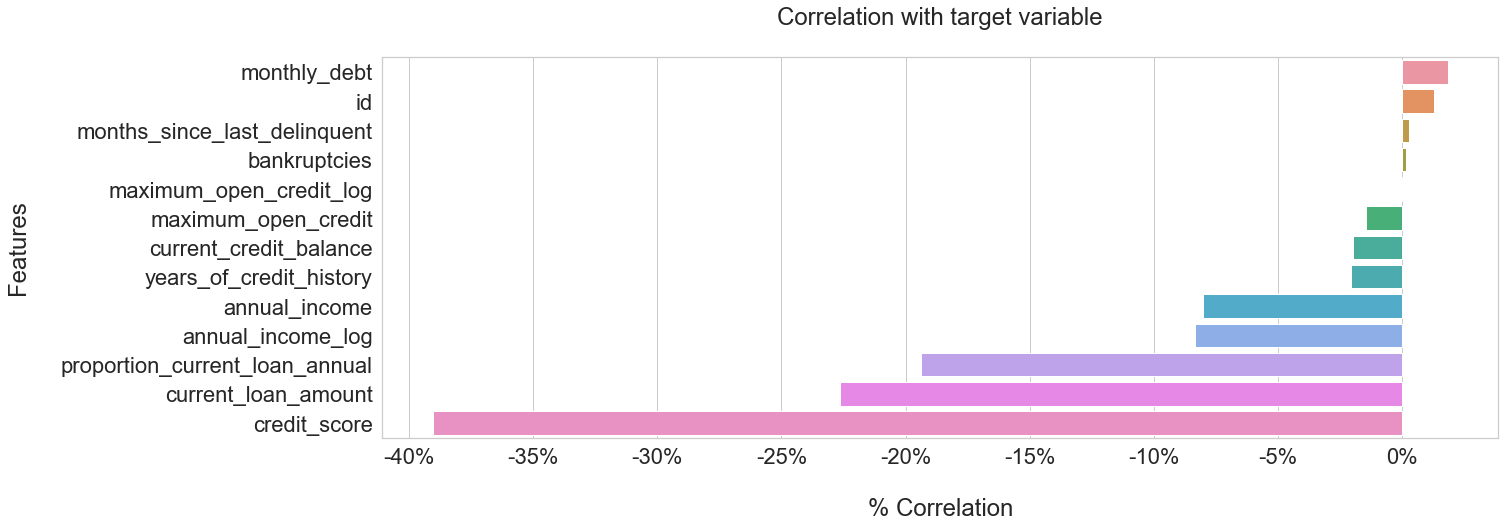

In [2374]:
#посмотрим на корреляцию итоговых данных
corr_with_target = df.corr()[TARGET_NAME].sort_values(ascending=False)[1:]

ax=sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

ax.set_title('Correlation with target variable\n')
ax.set_xlabel('\n% Correlation')
ax.set_xticklabels([f'{x:.0%}' for x in ax.get_xticks()])
ax.set_ylabel('Features\n');

In [2376]:
y_train_pred = model.predict(X_train[IMPORT_FEATURES])
y_test_pred  = model.predict(X_test[IMPORT_FEATURES])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.73      0.79      4328
           1       0.51      0.71      0.59      1672

    accuracy                           0.73      6000
   macro avg       0.69      0.72      0.69      6000
weighted avg       0.77      0.73      0.74      6000

TEST

              precision    recall  f1-score   support

           0       0.86      0.73      0.79      1059
           1       0.52      0.71      0.60       441

    accuracy                           0.72      1500
   macro avg       0.69      0.72      0.69      1500
weighted avg       0.76      0.72      0.73      1500

CONFUSION MATRIX

col_0             0    1
credit_default          
0               773  286
1               130  311


In [2377]:
# show_learning_curve_plot(model, X, y)

In [2378]:
y_test_pred_probs = model.predict_proba(X_test[IMPORT_FEATURES])

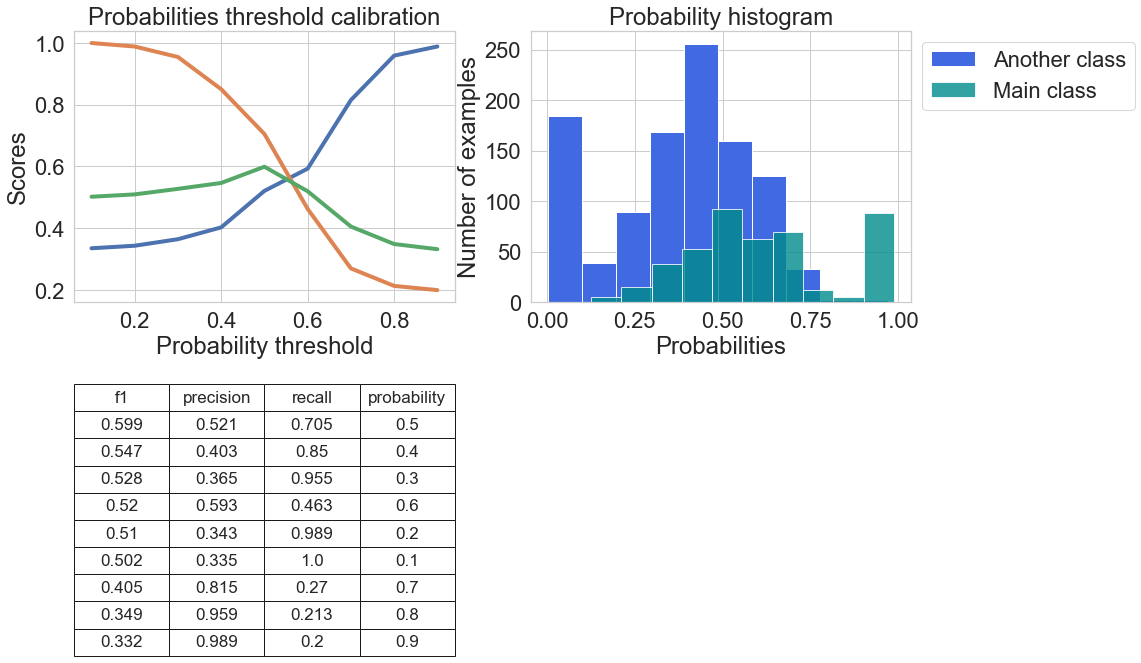

In [2379]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [2397]:
pred_test = np.where(y_test_pred_probs[:, 1] >= 0.5, 1, 0)

In [2398]:
print(f'f1-score = {f1_score(y_pred=pred_test, y_true=y_test):.3f}, \n\
взвешенный f1-score = {f1_score(y_pred=pred_test, y_true=y_test, average="weighted"):.3f}, \n\
f1-macro= {f1_score(y_pred=pred_test, y_true=y_test, average="macro"):.3f}')

f1-score = 0.599, 
взвешенный f1-score = 0.732, 
f1-macro= 0.694


In [2399]:
get_classification_report(y_train, y_train_pred, y_test, pred_test)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.73      0.79      4328
           1       0.51      0.71      0.59      1672

    accuracy                           0.73      6000
   macro avg       0.69      0.72      0.69      6000
weighted avg       0.77      0.73      0.74      6000

TEST

              precision    recall  f1-score   support

           0       0.86      0.73      0.79      1059
           1       0.52      0.71      0.60       441

    accuracy                           0.72      1500
   macro avg       0.69      0.72      0.69      1500
weighted avg       0.76      0.72      0.73      1500

CONFUSION MATRIX

col_0             0    1
credit_default          
0               773  286
1               130  311


***Прогнозирование на тестовой выборке.***

*Обучим модель на полном датасете.*

In [2400]:
final_model = model.fit(X[IMPORT_FEATURES],y,cat_features=NEW_CAT_FEATURES)

In [2401]:
df_test.head()

,home_ownership,annual_income,years_in_current_job,tax_liens,number_of_open_accounts,years_of_credit_history,maximum_open_credit,number_of_credit_problems,months_since_last_delinquent,bankruptcies,...,credit_score,annual_income_log,years_credit_history_rank,maximum_credit_rank,maximum_open_credit_log,current_loan_amount_rank,proportion_current_loan_annual,current_credit_balance_rank,credit_score_rank,strong_feature
0,Rent,9.884604e+05,4 years,0-1,1,12.5,220968.0,0,70.0,1,...,725.0,13.803904,10 - 30,less 0.25 quantile,12.305773,50000-450000,0.337014,less 1.000.000,700-740,1
1,Rent,2.318380e+05,1 year,0-1,1,32.7,55946.0,0,8.0,0,...,699.0,12.353794,more 30,less 0.25 quantile,10.932142,50000-450000,0.076352,less 1.000.000,less 700,1
2,Home,1.152540e+06,3 years,0-1,1,13.7,204600.0,0,32.0,0,...,-1.0,13.957479,10 - 30,less 0.25 quantile,12.228812,50000-450000,0.266402,less 1.000.000,-1,1
3,Home,1.220313e+06,10+ years,0-1,2,17.0,456302.0,0,70.0,1,...,739.0,14.014618,10 - 30,0.25-0.75 quantile,13.030910,50000-450000,0.270017,less 1.000.000,700-740,2
4,Home,2.340952e+06,6 years,0-1,1,23.6,1207272.0,0,32.0,0,...,706.0,14.666068,10 - 30,0.75-0.95 quantile,14.003874,more 800000,1.001765,less 1.000.000,700-740,1


In [2402]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   home_ownership                  2500 non-null   object  
 1   annual_income                   2500 non-null   float64 
 2   years_in_current_job            2500 non-null   object  
 3   tax_liens                       2500 non-null   category
 4   number_of_open_accounts         2500 non-null   object  
 5   years_of_credit_history         2500 non-null   float64 
 6   maximum_open_credit             2500 non-null   float64 
 7   number_of_credit_problems       2500 non-null   category
 8   months_since_last_delinquent    2500 non-null   float64 
 9   bankruptcies                    2500 non-null   int64   
 10  purpose                         2500 non-null   object  
 11  term                            2500 non-null   object  
 12  current_loan_amount 

In [2406]:
df_test.isna().sum()

home_ownership                    0
annual_income                     0
years_in_current_job              0
tax_liens                         0
number_of_open_accounts           0
years_of_credit_history           0
maximum_open_credit               0
number_of_credit_problems         0
months_since_last_delinquent      0
bankruptcies                      0
purpose                           0
term                              0
current_loan_amount               0
current_credit_balance            0
monthly_debt                      0
credit_score                      0
annual_income_log                 0
years_credit_history_rank         0
maximum_credit_rank               0
maximum_open_credit_log           0
current_loan_amount_rank          0
proportion_current_loan_annual    0
current_credit_balance_rank       0
credit_score_rank                 0
strong_feature                    0
dtype: int64

In [2424]:
df_test.number_of_open_accounts = df_test.number_of_open_accounts.apply(str)

In [2425]:
NEW_CAT_FEATURES

['current_loan_amount_rank',
 'strong_feature',
 'term',
 'home_ownership',
 'number_of_open_accounts',
 'purpose',
 'bankruptcies',
 'years_credit_history_rank',
 'credit_score_rank',
 'number_of_credit_problems',
 'tax_liens']

In [2426]:
course_test_pool = catb.Pool(df_test[IMPORT_FEATURES], cat_features=NEW_CAT_FEATURES)

In [2428]:
target_pred_prob = final_model.predict_proba(course_test_pool)
target_pred = np.where(target_pred_prob[:, 1] >= 0.5, 1, 0)

In [2429]:
target_pred = pd.DataFrame(target_pred)
submission_target = target_pred.rename(columns={0:'Credit Default'})

In [2430]:
submission_target.to_csv('VASminov_solution_NEW_final.csv')